<a href="https://colab.research.google.com/github/amadousysada/scoring-model/blob/master/00_analyse_exploratoire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="text-align:center; font-size:3.3em; color:#AD7D67; line-height:5rem; font-style:italic; font-weight:700;">
    Projet N°4 : <br>
    Implémentation d'un modèle de scoring </p>
<p style="text-align:center; font-size:2.8em; color:#9EBEB8; line-height:4rem; font-style:italic; font-weight:700;">
    I - Analyse Exploratoire des Données
</p>

# Sommaire
 1. [Présentation des données](#Présentation-des-données)
 2. [Import des des librairies](#Imports)
 3. [Chargement des données](#Chargement-des-données)
 4. [Exploration de la variable cible](#Exploration-de-la-colonne-cible)
 5. [Exploration des valeurs manquantes](#Exploration-des-valeurs-manquantes)
 6. [Exploration des Anomalies(outliers)](#Exploration-des-Anomalies-(outliers))
 7. [Analyse univariée](#Analyse-univariée)

# Présentation des données

Les données sont fournies par [Home Credit](http://www.homecredit.net/about-us.aspx), un service dédié à offrir des lignes de crédit (prêts) à la population non bancarisée. Prédire si un client remboursera un prêt ou rencontrera des difficultés est un besoin critique pour l'entreprise. Home Credit organise ce concours sur Kaggle pour voir quels types de modèles la communauté du machine learning peut développer pour les aider dans cette tâche.

Il existe 7 sources de données différentes :

- **application_train/application_test** : les données principales d'entraînement et de test contenant des informations sur chaque demande de prêt chez Home Credit. Chaque prêt correspond à une ligne et est identifié par la variable `SK_ID_CURR`. Les données d'entraînement incluent la variable cible `TARGET`, qui indique :  
  - 0 : le prêt a été remboursé,  
  - 1 : le prêt n'a pas été remboursé.
  
- **bureau** : des données concernant les crédits précédents des clients auprès d'autres institutions financières. Chaque crédit précédent correspond à une ligne dans le tableau `bureau`, mais un prêt dans les données d'application peut être associé à plusieurs crédits précédents.

- **bureau_balance** : des données mensuelles sur les crédits précédents dans `bureau`. Chaque ligne représente un mois d'un crédit précédent, et un seul crédit peut avoir plusieurs lignes correspondant à chaque mois de sa durée.

- **previous_application** : les demandes de prêt précédentes des clients qui ont des prêts dans les données d'application. Chaque prêt actuel peut être lié à plusieurs prêts précédents. Chaque demande précédente correspond à une ligne et est identifiée par la variable `SK_ID_PREV`.

- **POS_CASH_BALANCE** : des données mensuelles sur les prêts antérieurs liés à des points de vente ou des prêts en espèces que les clients ont contractés chez Home Credit. Chaque ligne représente un mois d'un prêt précédent, et un seul prêt précédent peut avoir de nombreuses lignes.

- **credit_card_balance** : des données mensuelles sur les cartes de crédit précédentes des clients chez Home Credit. Chaque ligne représente un mois du solde d'une carte de crédit, et une seule carte de crédit peut avoir plusieurs lignes.

- **installments_payment** : l'historique des paiements pour les prêts précédents chez Home Credit. Chaque ligne correspond soit à un paiement effectué, soit à un paiement manqué.

## Imports

Nous utilisons les librairies : `numpy`, `pandas`, `sklearn`, `matplotlib`, `scipty`.

In [110]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from scipy import stats

import os

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 122)

## Chargement des données

Il y a un total de 9 fichiers :

- 1 fichier principal pour l'entraînement (avec la variable cible),  
- 1 fichier principal pour le test (sans la variable cible),  
- 1 fichier d'exemple de soumission,  
- et 6 autres fichiers contenant des informations supplémentaires sur chaque prêt.

In [111]:
folder_path = "/content/drive/MyDrive/data/" # A ajuster selon le chemin où se trouve vos cvs.

In [112]:
# Liste des fichiers disponibles
print(os.listdir(folder_path))

['HomeCredit_columns_description.csv', 'credit_card_balance.csv', 'bureau_balance.csv', 'POS_CASH_balance.csv', 'application_test.csv', 'bureau.csv', 'sample_submission.csv', 'installments_payments.csv', 'previous_application.csv', 'application_train.csv', '.ipynb_checkpoints', '01_cleaned_app_train.csv', '01_cleaned_app_test.csv', 'final_cleaned_app_test.csv', 'final_cleaned_app_train.csv', 'grid_search_results.pkl', 'final_model.pkl', 'cleaned_app_train.csv', 'cleaned_app_test.csv']


In [113]:
description_data = pd.read_csv(f"{folder_path}HomeCredit_columns_description.csv", encoding='ISO-8859-1')
pd.set_option('display.max_colwidth', None)
description_data

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...,...
214,217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
215,218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was supposed to be paid (relative to application date of current loan),time only relative to the application
216,219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit paid actually (relative to application date of current loan),time only relative to the application
217,220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of previous credit on this installment,NaN


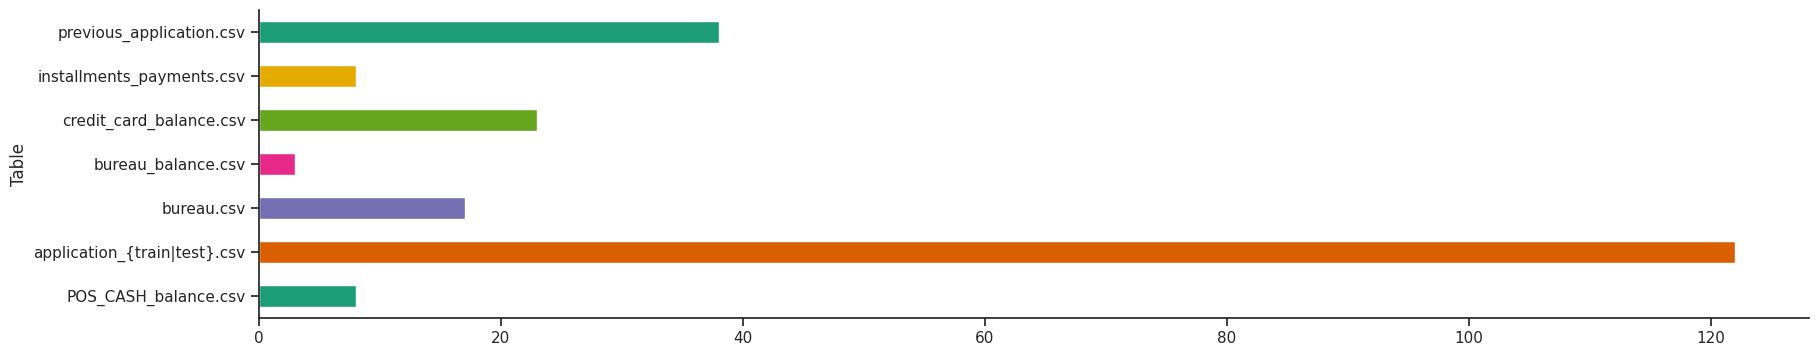

In [114]:
from matplotlib import pyplot as plt
import seaborn as sns
description_data.groupby('Table').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [115]:
# Données d'entrainement
app_train = pd.read_csv(f"{folder_path}/application_train.csv")
print('Dimensions des données d’entraînement : ', app_train.shape)
app_train.head()

Dimensions des données d’entraînement :  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


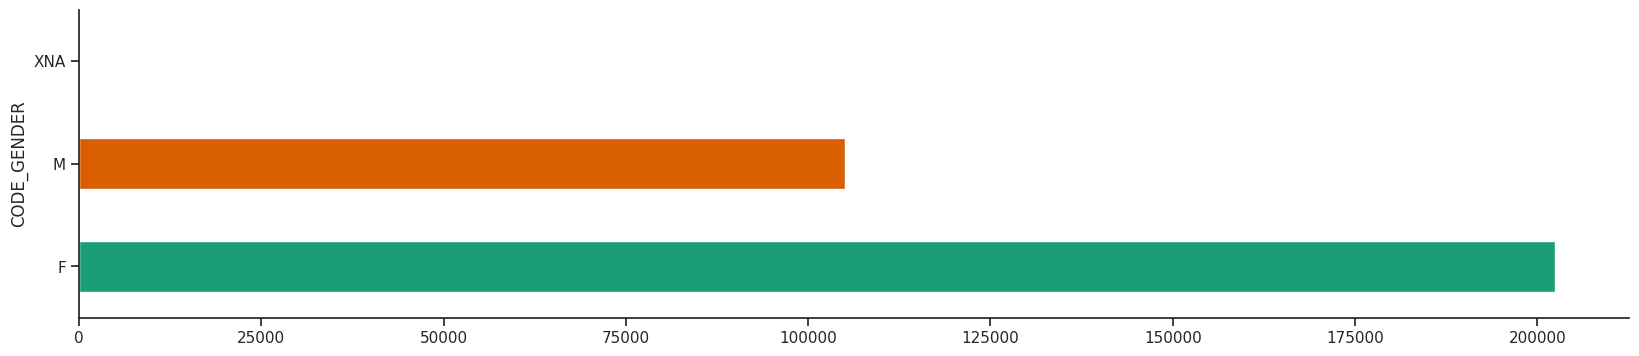

In [116]:
from matplotlib import pyplot as plt
import seaborn as sns
app_train.groupby('CODE_GENDER').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [117]:
print(app_train['FLAG_OWN_REALTY'].value_counts())


FLAG_OWN_REALTY
Y    213312
N     94199
Name: count, dtype: int64


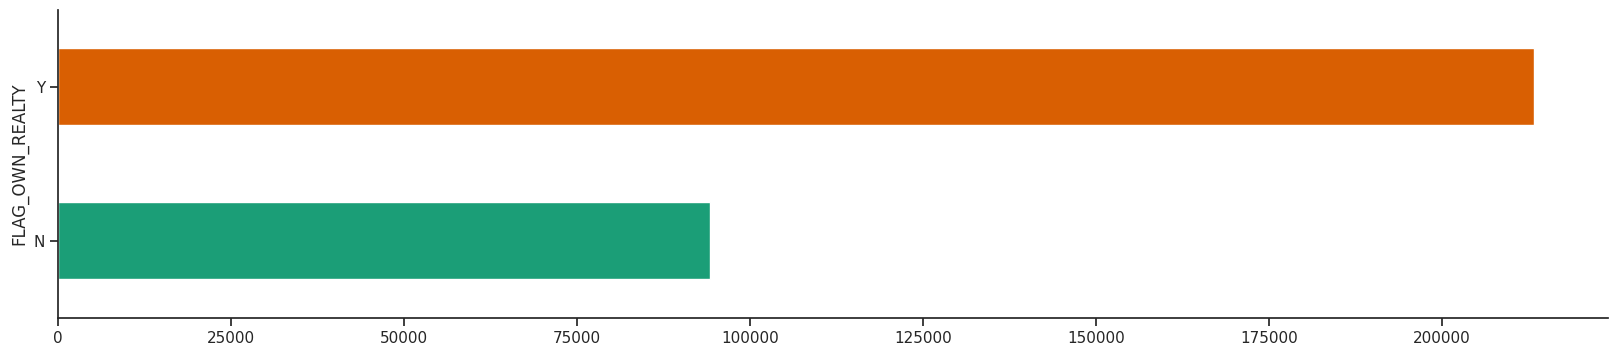

In [118]:
from matplotlib import pyplot as plt
import seaborn as sns
app_train.groupby('FLAG_OWN_REALTY').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

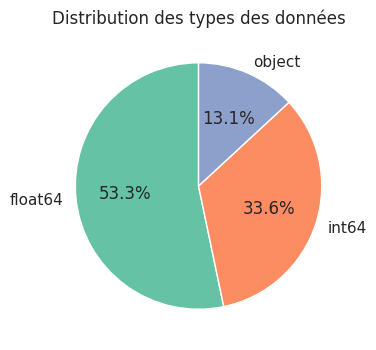

In [119]:
dtype_counts = app_train.dtypes.value_counts()

dtype_counts.plot.pie(autopct="%1.1f%%", labels=dtype_counts.index, startangle=90, colors=["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3"])
plt.title("Distribution des types des données")
plt.ylabel("")  # Remove default ylabel
plt.show()

Le total de valeurs manquante est de: 9152465, soit un pourcenatge de 24.39594190712943


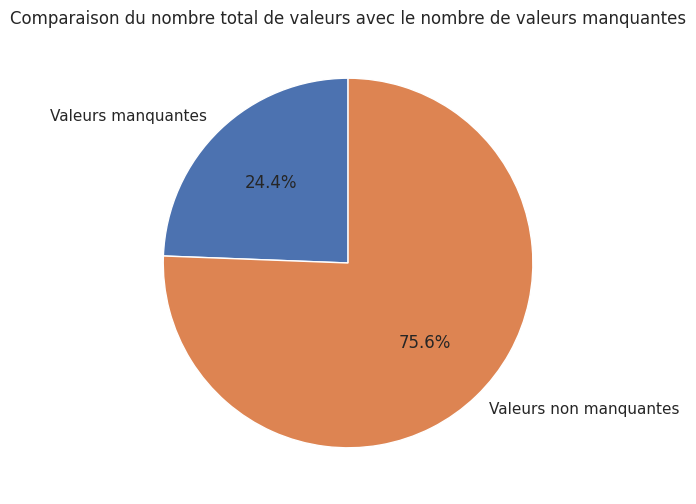

In [120]:
# Le total de valeurs manquantes
missing_values = app_train.isna().sum()

total_missing_values = missing_values.sum()
print(f"Le total de valeurs manquante est de: {total_missing_values}, soit un pourcenatge de {100*(total_missing_values / app_train.size)}" )
labels = ['Valeurs manquantes', 'Valeurs non manquantes']

values = [total_missing_values, app_train.size - total_missing_values]

plt.figure(figsize=(8, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)

plt.title("Comparaison du nombre total de valeurs avec le nombre de valeurs manquantes")

plt.show()

Les données d’entraînement contiennent 307511 observations (chacune correspondant à un prêt distinct) et 122 caractéristiques (variables), y compris la variable TARGET (le label que nous souhaitons prédire).

In [121]:
# Données de tests
app_test = pd.read_csv(f"{folder_path}application_test.csv")
print('Dimensions des données de test: ', app_test.shape)
app_test.head()

Dimensions des données de test:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## Exploration de la colonne cible

La cible est ce que nous devons prédire : soit un 0 si le prêt a été remboursé à temps, soit un 1 indiquant que le client a rencontré des difficultés de paiement. Nous pouvons commencer par examiner le nombre de prêts dans chaque catégorie.

In [122]:
app_train['TARGET'].value_counts()

,count
TARGET,
0,282686
1,24825


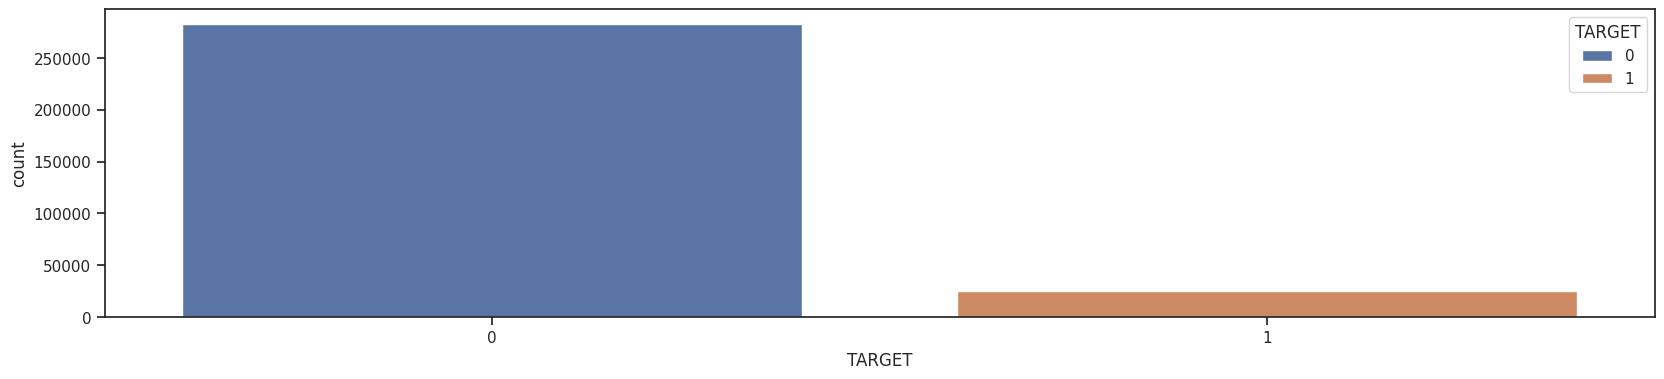

In [123]:
fig, ax = plt.subplots()
sns.countplot(data=app_train, x='TARGET', ax=ax, hue='TARGET')
xticks = ax.xaxis.get_ticks_position()
ax.xaxis.set_ticks([0, 1])
plt.show()

À partir de ces informations, nous constatons qu'il s'agit d'un problème de classes déséquilibrées. Il y a beaucoup plus de prêts remboursés à temps que de prêts non remboursés. Lorsque nous utiliserons des modèles de machine learning plus sophistiqués, nous pourrons pondérer les classes en fonction de leur représentation dans les données afin de tenir compte de ce déséquilibre.

## Exploration des valeurs manquantes

In [124]:
# Fonction pour calcluer le pourcentage de valeurs manquantes par colonne
def missing_values_table(df):
        mis_val = df.isnull().sum()

        mis_val_percent = 100 * df.isnull().mean()

        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        print ("Le dataframe contient " + str(df.shape[1]) + " colonnes.\n"
            "Il ya " + str(mis_val_table_ren_columns.shape[0]) +
              " colonnes presentant des valeurs manquantes.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [125]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values

Le dataframe contient 122 colonnes.
Il ya 67 colonnes presentant des valeurs manquantes.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


La majorité des modèles de machine learning ne supporte pas les valeurs manquantes, ce qui rend nécessaire un traitement spécifique des données manquantes.

Dans notre cas, nous allons supprimer toutes les variables ayant un taux d'incomplétude supérieur à 50 %.

Nous avons remarqué que ces variables correspondent toutes à des caractéristiques liées à l'habitation du client.

Pour le reste des vaeurs nous les traiterons plus tard

In [126]:
cols_to_drop = [col for col in app_train.columns
                if (100 * app_train[col].isnull().mean()) >= 50]
app_train  = app_train.drop(columns=cols_to_drop)

In [127]:
missing_values_table(app_train)

Le dataframe contient 81 colonnes.
Il ya 26 colonnes presentant des valeurs manquantes.


,Missing Values,% of Total Values
FLOORSMAX_AVG,153020,49.8
FLOORSMAX_MODE,153020,49.8
FLOORSMAX_MEDI,153020,49.8
YEARS_BEGINEXPLUATATION_AVG,150007,48.8
YEARS_BEGINEXPLUATATION_MODE,150007,48.8
YEARS_BEGINEXPLUATATION_MEDI,150007,48.8
TOTALAREA_MODE,148431,48.3
EMERGENCYSTATE_MODE,145755,47.4
OCCUPATION_TYPE,96391,31.3
EXT_SOURCE_3,60965,19.8


Le total de valeurs manquante est de: 1616066, soit un pourcenatge de 6.48803850879007


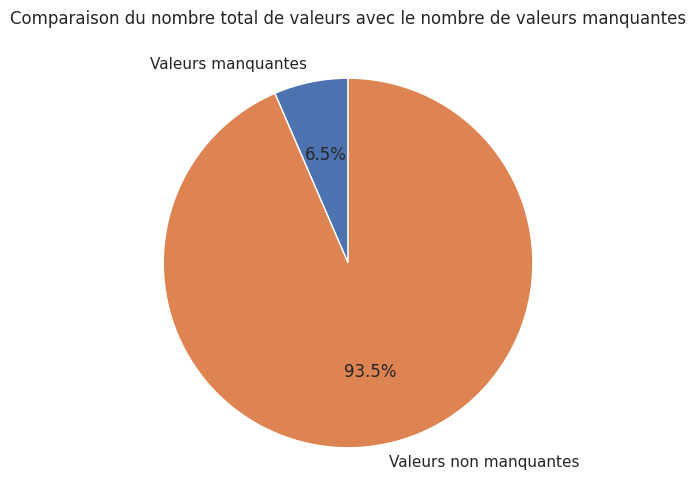

In [128]:
# Le total de valeurs manquantes
missing_values = app_train.isna().sum()

total_missing_values = missing_values.sum()
print(f"Le total de valeurs manquante est de: {total_missing_values}, soit un pourcenatge de {100*(total_missing_values / app_train.size)}" )
labels = ['Valeurs manquantes', 'Valeurs non manquantes']

values = [total_missing_values, app_train.size - total_missing_values]

plt.figure(figsize=(8, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)

plt.title("Comparaison du nombre total de valeurs avec le nombre de valeurs manquantes")

plt.show()

In [129]:
# Aligner les deux datasets
train_labels = app_train['TARGET']

app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)
app_train['TARGET'] = train_labels

## Exploration des Anomalies (outliers)

Un problème auquel nous devons toujours prêter attention lors de l'analyse exploratoire des données (EDA) est la présence d'anomalies dans les données. Celles-ci peuvent être dues à des erreurs de saisie, à des défauts dans les équipements de mesure, ou elles peuvent représenter des valeurs valides mais extrêmes. Une façon de soutenir l'identification des anomalies de manière quantitative est d'examiner les statistiques d'une colonne en utilisant la méthode describe.

In [130]:
# Description de l'ensemble des variables quantitatives
app_train.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
count,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,307511.000000
mean,278180.518577,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,...,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974,0.080729
std,102790.175348,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,3522.886321,...,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295,0.272419
min,100002.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,-24672.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,-7479.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,-4504.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,367142.500000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,-2010.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
max,456255.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,0.000000,...,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000,1.000000


#### `DAYS_BIRTH`

Les nombres dans la colonne `DAYS_BIRTH` sont négatifs parce qu'ils sont enregistrés par rapport à la demande de prêt actuelle. Pour voir ces statistiques en années, nous pouvons multiplier par -1 et diviser par le nombre de jours dans une année.

In [131]:
(app_train['DAYS_BIRTH'] / -365).describe()

,DAYS_BIRTH
count,307511.000000
mean,43.936973
std,11.956133
min,20.517808
25%,34.008219
50%,43.150685
75%,53.923288
max,69.120548


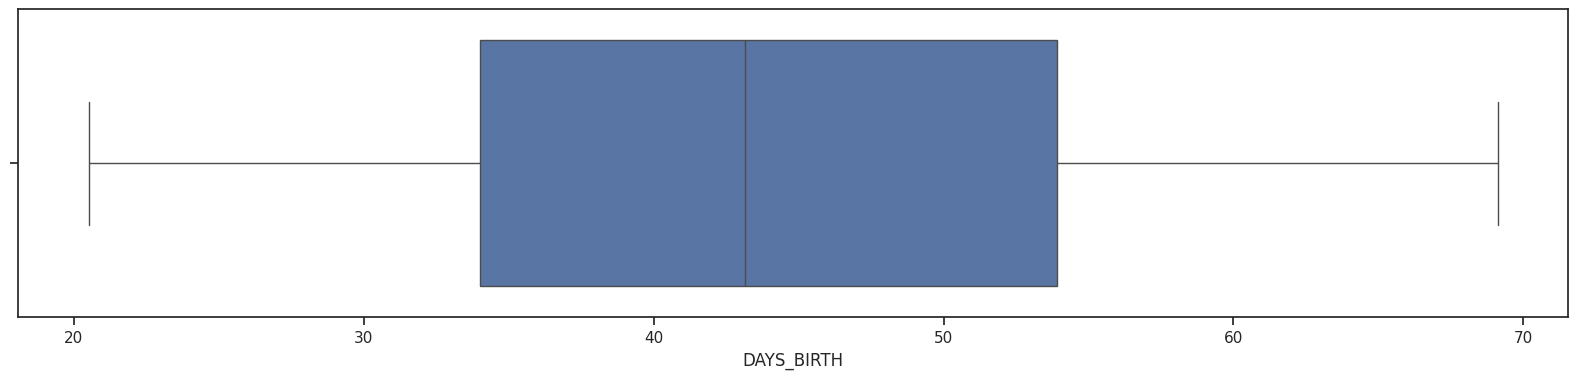

In [132]:
sns.boxplot(x=(app_train['DAYS_BIRTH'] / -365))
plt.show()

Ces statistiques semblent raisonables. Il n'y a pas d'outliers pour l'âge.

#### `DAYS_EMPLOYED`
La variabe `DAYS_EMPLOYED` represente le nombre de jour avant la demande pendant lequel la personne a commencé son emploi actuel. Elle est exprimée en valeur negative.

Pour vérifier les anomalies dans la variable, nous allons procéder de la même manière que pour DAYS_BIRTH.

In [133]:
app_train['DAYS_EMPLOYED'].describe()

,DAYS_EMPLOYED
count,307511.000000
mean,63815.045904
std,141275.766519
min,-17912.000000
25%,-2760.000000
50%,-1213.000000
75%,-289.000000
max,365243.000000


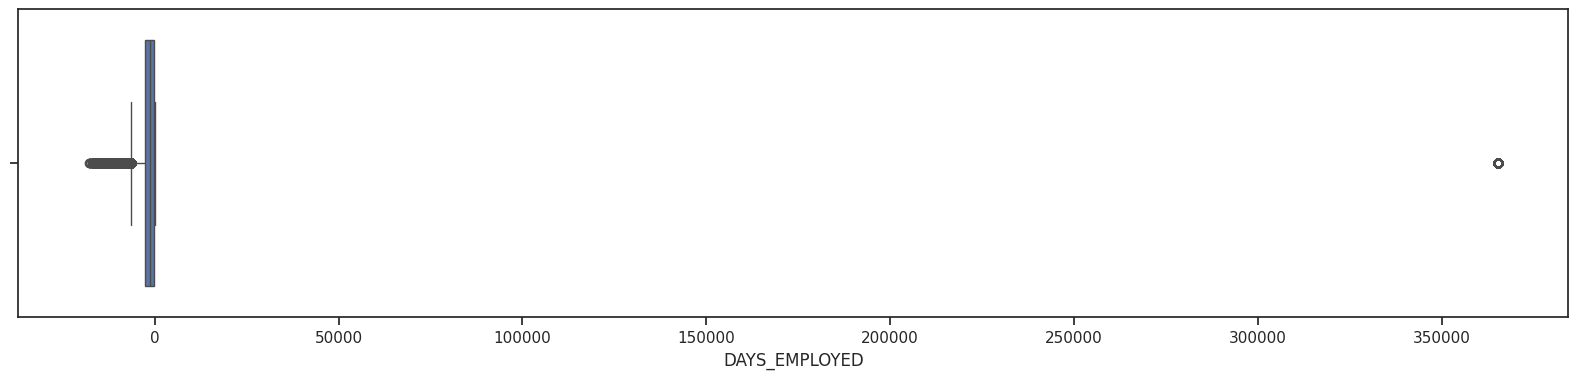

In [134]:
sns.boxplot(x=(app_train['DAYS_EMPLOYED']))
plt.show()

La description statistique de la variable montre une valeur maximale positive qui pourrait correspondre à 1000 années de travail, ce qui est impossible.

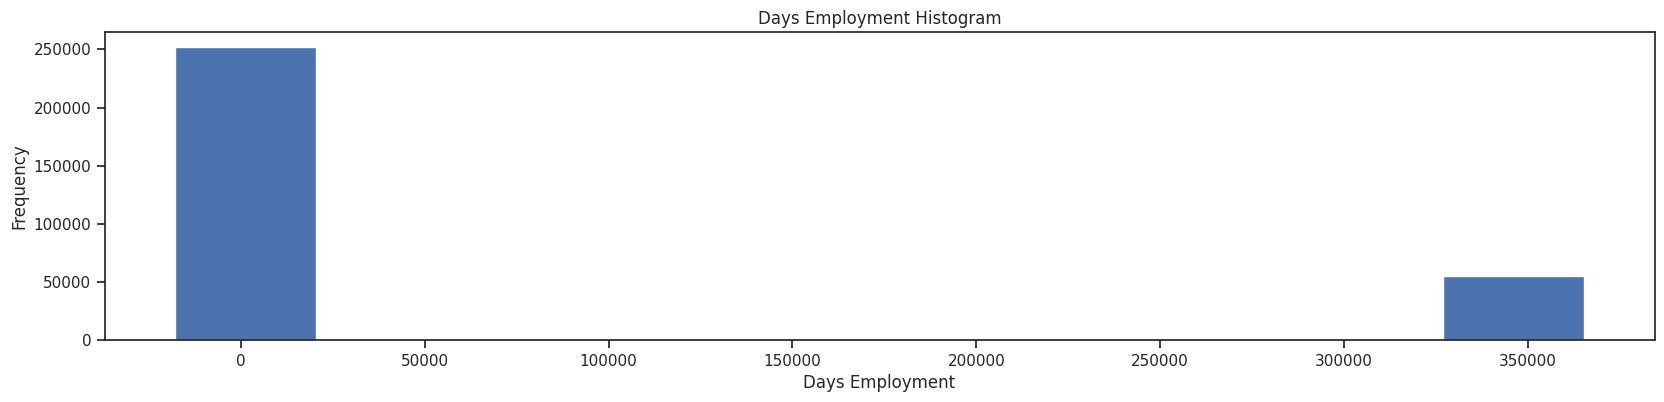

In [135]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Par simple curiosité, examinons les clients anormaux et voyons s'ils ont des taux de défaut plus élevés ou plus bas que les autres clients.

In [136]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('Les clients normaux ont un taux de défaut de %0.2f%%  sur les prêts' % (100 * non_anom['TARGET'].mean()))
print('Les clients anormaux ont un taux de défaut de %0.2f%% sur les prêts' % (100 * anom['TARGET'].mean()))
print('Il y a %d jours d\'emploi anormaux.' % len(anom))

Les clients normaux ont un taux de défaut de 8.66%  sur les prêts
Les clients anormaux ont un taux de défaut de 5.40% sur les prêts
Il y a 55374 jours d'emploi anormaux.


Il s'avère que les anomalies ont un taux de défaut plus faible.

Le traitement des anomalies dépend de la situation exacte, sans règles strictes. L'une des approches les plus sûres consiste simplement à définir les anomalies comme des valeurs manquantes, puis à les remplir (par imputation) avant d'appliquer les modèles de machine learning. Dans ce cas, comme toutes les anomalies ont exactement la même valeur, nous voulons les remplir avec la même valeur, au cas où tous ces prêts partageraient quelque chose en commun. Les valeurs anormales semblent avoir une certaine importance, nous voulons donc informer le modèle de machine learning si nous avons effectivement rempli ces valeurs. Comme solution, nous allons remplir les valeurs anormales avec une valeur `np.nan` (pas un nombre), puis créer une nouvelle colonne booléenne indiquant si la valeur était anormale ou non.

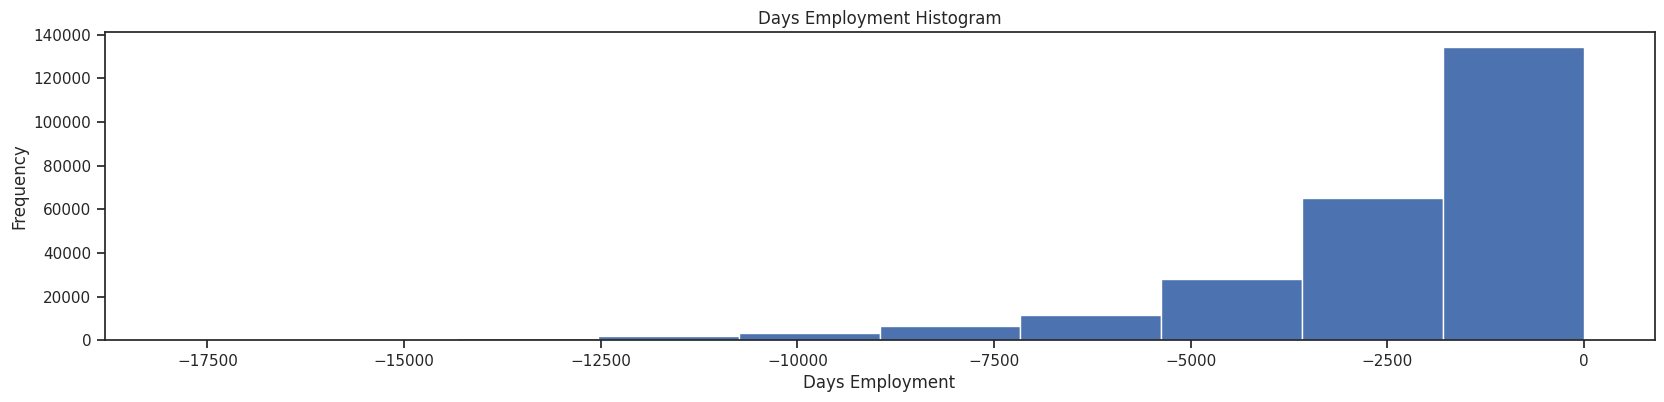

In [137]:
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [138]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('Il y a %d anomalies dans les données de test sur %d entrées' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

Il y a 9274 anomalies dans les données de test sur 48744 entrées


## Analyse univariée

### variables catégorielles

Dans cette partie nous allons analyser les vraiables categorielles.

In [139]:
def bar_plot(df, col, title, orient="v"):
    """
    Crée un diagramme à barres pour une colonne spécifique d'un DataFrame.

    Paramètres :
    ------------
    df : pandas.DataFrame
        Le DataFrame contenant les données à visualiser.
    col : str
        Le nom de la colonne du DataFrame à représenter sous forme de diagramme à barres.
    title : str
        Le titre du graphique.
    orient: str, default='v'
        L'orientation de la diagramme.

    Retourne :
    ----------
    None
        La fonction affiche le graphique mais ne retourne aucune valeur.
    """
    fig, ax = plt.subplots()

    params = {
        'x': col if orient=="v" else None,
        'y': col if orient=="h" else None,
    }
    sns.countplot(
        data=df,
        y=col if orient=="h" else None,
        x=col if orient=="v" else None,
        hue=col,
        ax=ax
    )

    total = len(df)
    for patch in ax.patches:
        count = patch.get_width() if orient=='h' else patch.get_height()
        percentage = f"{(count / total) * 100:.2f}%"

        if(orient=='v'):
            ax.text(
                patch.get_x() + patch.get_width() / 2,
                count + 0.2,
                f"{count}({percentage})",
                ha='center',
                color='darkblue',
                fontweight='bold',
            )
        else:
            ax.text(
                count / 2,
                patch.get_y() + patch.get_height() / 2,
                f"{count}({percentage})",
                va='center',
                color='darkblue',
                fontweight='bold',
                #bbox=dict(facecolor='lightyellow', alpha=0.5)
            )

    plt.title(title, loc="center", fontsize=18, fontstyle='italic')
    plt.show()

In [140]:
app_train.describe(include='O').T

,count,unique,top,freq
NAME_CONTRACT_TYPE,307511,2,Cash loans,278232
CODE_GENDER,307511,3,F,202448
FLAG_OWN_CAR,307511,2,N,202924
FLAG_OWN_REALTY,307511,2,Y,213312
NAME_TYPE_SUITE,306219,7,Unaccompanied,248526
NAME_INCOME_TYPE,307511,8,Working,158774
NAME_EDUCATION_TYPE,307511,5,Secondary / secondary special,218391
NAME_FAMILY_STATUS,307511,6,Married,196432
NAME_HOUSING_TYPE,307511,6,House / apartment,272868
OCCUPATION_TYPE,211120,18,Laborers,55186


#### *CODE_GENDER*

In [141]:
app_train.CODE_GENDER.value_counts()

,count
CODE_GENDER,
F,202448
M,105059
XNA,4


Nous avons ici observations dont le genre est `XNA`, pour ces observations nous allons remplacer les valeurs par la modalité la plus fréquente (F)

In [142]:
app_train.CODE_GENDER.where(app_train['CODE_GENDER'] != 'XNA', 'F', inplace=True)

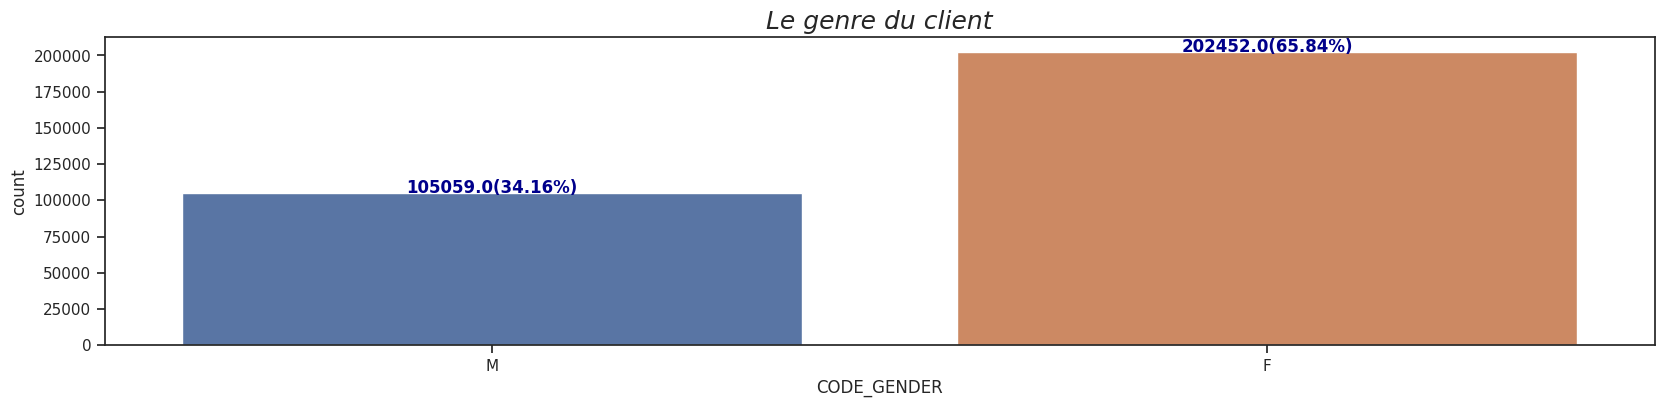

In [143]:
bar_plot(app_train, 'CODE_GENDER', title='Le genre du client')

#### *NAME_TYPE_SUITE*

In [144]:
app_train.NAME_TYPE_SUITE.value_counts()

,count
NAME_TYPE_SUITE,
Unaccompanied,248526
Family,40149
"Spouse, partner",11370
Children,3267
Other_B,1770
Other_A,866
Group of people,271


Nous allons reduire les modalités en seulement deux catégories: **accompanied** et **unaccompanied**

In [145]:
map_type_suite = {
    'Unaccompanied': 'Unaccompanied',
    'Family': 'Accompanied',
    'Spouse, partner': 'Accompanied',
    'Children': 'Accompanied',
    'Other_B': 'Accompanied',
    'Other_A':'Accompanied',
    'Group of people': 'Accompanied'
}
app_train.NAME_TYPE_SUITE = app_train.NAME_TYPE_SUITE.map(map_type_suite)
# Appliquer ce changement au dataset test
app_test.NAME_TYPE_SUITE = app_test.NAME_TYPE_SUITE.map(map_type_suite)

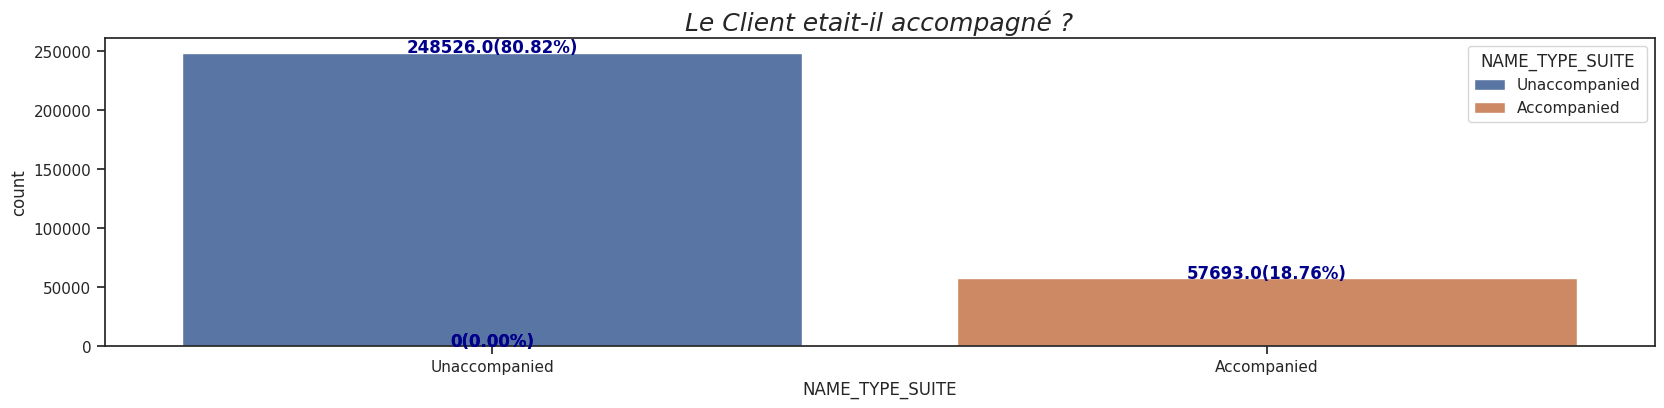

In [146]:
bar_plot(app_train, 'NAME_TYPE_SUITE', title='Le Client etait-il accompagné ?')

### variables quantitatives


In [147]:
app_train.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0,278180.518577,102790.175348,1.000020e+05,189145.500000,278202.000000,367142.500000,4.562550e+05
CNT_CHILDREN,307511.0,0.417052,0.722121,0.000000e+00,0.000000,0.000000,1.000000,1.900000e+01
AMT_INCOME_TOTAL,307511.0,168797.919297,237123.146279,2.565000e+04,112500.000000,147150.000000,202500.000000,1.170000e+08
AMT_CREDIT,307511.0,599025.999706,402490.776996,4.500000e+04,270000.000000,513531.000000,808650.000000,4.050000e+06
AMT_ANNUITY,307499.0,27108.573909,14493.737315,1.615500e+03,16524.000000,24903.000000,34596.000000,2.580255e+05
AMT_GOODS_PRICE,307233.0,538396.207429,369446.460540,4.050000e+04,238500.000000,450000.000000,679500.000000,4.050000e+06
REGION_POPULATION_RELATIVE,307511.0,0.020868,0.013831,2.900000e-04,0.010006,0.018850,0.028663,7.250800e-02
DAYS_BIRTH,307511.0,-16036.995067,4363.988632,-2.522900e+04,-19682.000000,-15750.000000,-12413.000000,-7.489000e+03
DAYS_EMPLOYED,252137.0,-2384.169325,2338.360162,-1.791200e+04,-3175.000000,-1648.000000,-767.000000,0.000000e+00
DAYS_REGISTRATION,307511.0,-4986.120328,3522.886321,-2.467200e+04,-7479.500000,-4504.000000,-2010.000000,0.000000e+00


In [148]:
def multiple_plots(df, col, title):
    """
    Cette fonction affiche trois graphiques pour chaque colonne données du dataset df

     Paramètres :
    ------------
    df : pandas.DataFrame
        Le DataFrame contenant les données à visualiser.
    col : str
        Le nom de la colonne du DataFrame à représenter sous forme de diagramme à barres.
    title : str
        Le titre du graphique.

    Retourne :
    ----------
    None
        La fonction affiche les graphique mais ne retourne aucune valeur.

    """

    sns.set(style="ticks", rc = {'figure.figsize':(20, 4)})

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[col], bins=30, kde=True, line_kws={"color": "red"})
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[col], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[col])
    plt.title('Boxplot')

    plt.suptitle(f"{title}",
                 y=1.05, fontsize=20, fontstyle='italic')

    plt.show()

#### *CNT_CHILDREN*

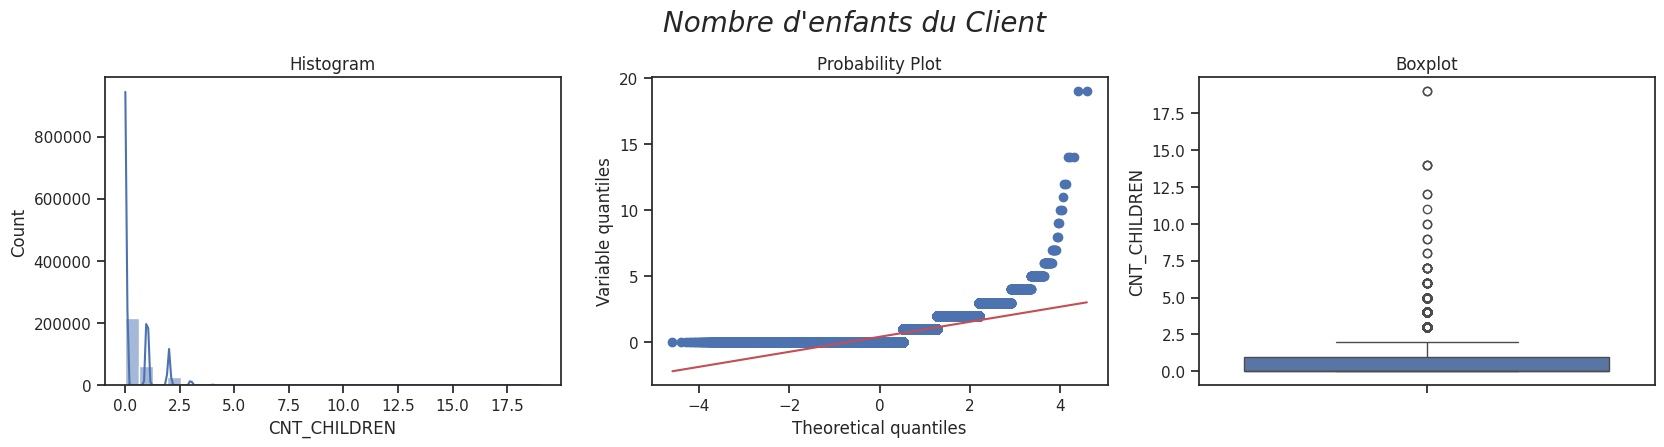

In [149]:
multiple_plots(app_train, 'CNT_CHILDREN', "Nombre d'enfants du Client")

La boite à moustache nous montre qu'il ya des valeurs projetée en dehors de la boite, naturellement on pourrait croire à une valeur abberante sauf dans ce contexte, on les gerera autrement.

Nous allons la proportion de ces valeurs par rapport aux valeurs qui semblent plus raisonables ensuite nous transformerons la variable en variable qualitative regroupant les données en 3 modalité: `sans_enfant`, `un_enfant` et `deux_enfants_ou_plus`.

L'avantage avec cette approche est que nous reduisons l'effet des valeurs extrêmes qui peuvent biaiser les résultats d’une analyse ou la performance d’un modèle.

In [150]:
childreen_0 = app_train[app_train.CNT_CHILDREN == 0]
childreen_1 = app_train[app_train.CNT_CHILDREN == 1]
childreen_2_plus = app_train[app_train.CNT_CHILDREN >= 2]

values = [childreen_0.shape[0], childreen_1.shape[0], childreen_2_plus.shape[0]]

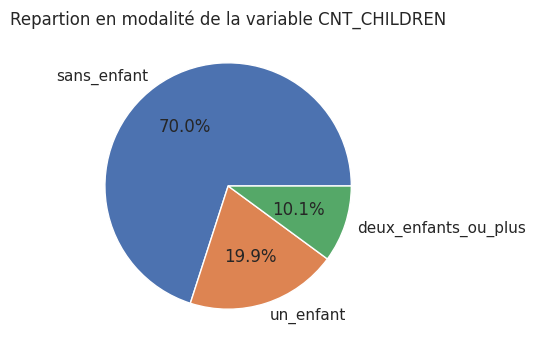

In [151]:
plt.pie(x=values, labels=['sans_enfant', 'un_enfant', 'deux_enfants_ou_plus'], autopct='%1.1f%%')
plt.title("Repartion en modalité de la variable CNT_CHILDREN")
plt.show()

In [152]:
# Transformation de la variable numérique 'CNT_CHILDREN' en variable qualitative de l'ensemble de train

app_train['nbr_enfants'] = app_train['CNT_CHILDREN']

app_train['nbr_enfants'] = np.where(app_train['CNT_CHILDREN'] == 0, 'sans_enfant', app_train['nbr_enfants'])

app_train['nbr_enfants'] = np.where(app_train['CNT_CHILDREN'] == 1, 'un_enfant', app_train['nbr_enfants'])

app_train['nbr_enfants'] = np.where(app_train['CNT_CHILDREN'] >= 2, 'deux_enfants_et_plus', app_train['nbr_enfants'])

# Transformation de la variable numérique 'CNT_CHILDREN' en variable qualitative de l'ensemble de test

app_test['nbr_enfants'] = app_test['CNT_CHILDREN']

app_test['nbr_enfants'] = np.where(app_test['CNT_CHILDREN'] == 0, 'sans_enfant', app_test['nbr_enfants'])

app_test['nbr_enfants'] = np.where(app_test['CNT_CHILDREN'] == 1, 'un_enfant', app_test['nbr_enfants'])

app_test['nbr_enfants'] = np.where(app_test['CNT_CHILDREN'] >= 2, 'deux_enfants_et_plus', app_test['nbr_enfants'])

# Suppression de la colonne CNT_CHILDREN
app_train.drop(labels='CNT_CHILDREN', axis=1, inplace=True)
app_test.drop(labels='CNT_CHILDREN', axis=1, inplace=True)

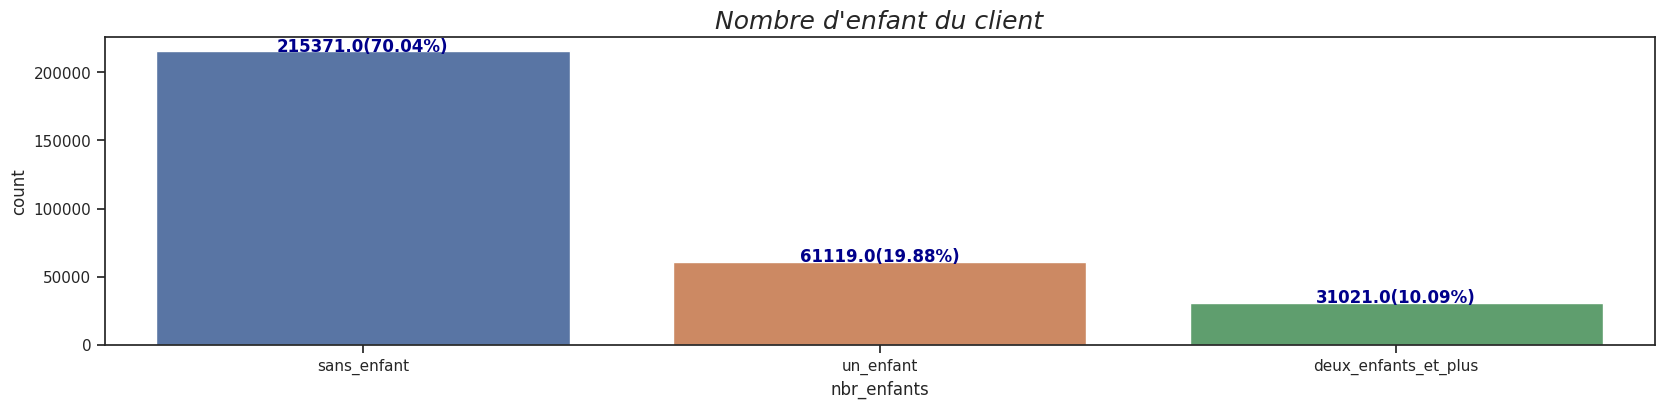

In [153]:
bar_plot(app_train, 'nbr_enfants', "Nombre d'enfant du client")

#### *AMT_INCOME_TOTAL*, *AMT_CREDIT*, *AMT_ANNUITY*, *AMT_GOODS_PRICE*, *EXT_SOURCE_2*

In [154]:
cols = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'EXT_SOURCE_2','EXT_SOURCE_3']

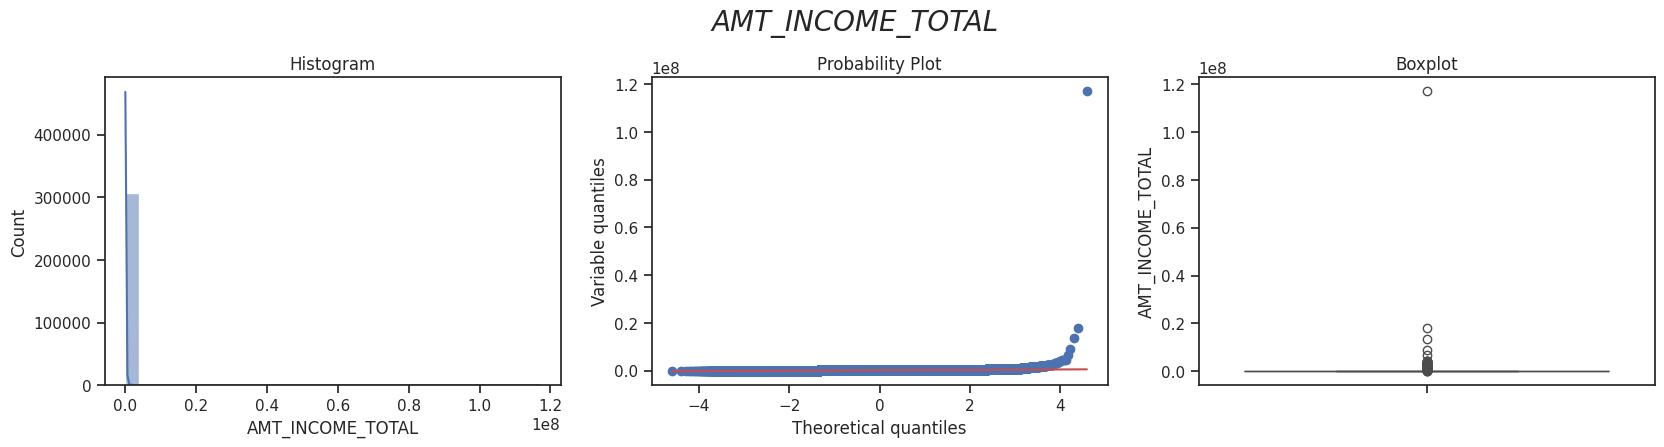

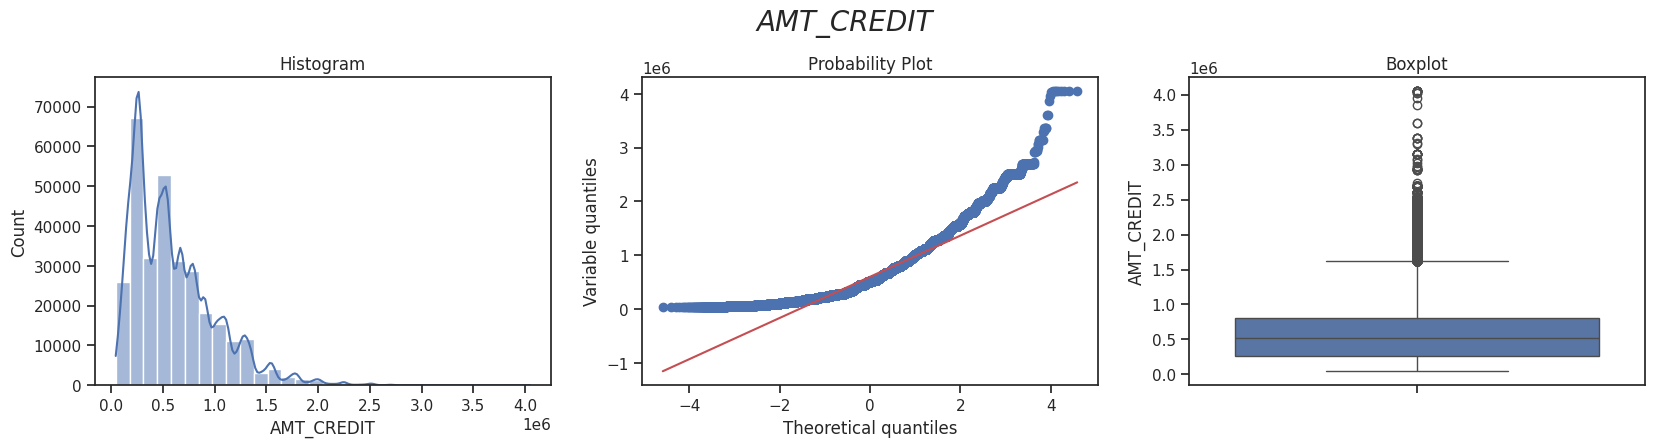

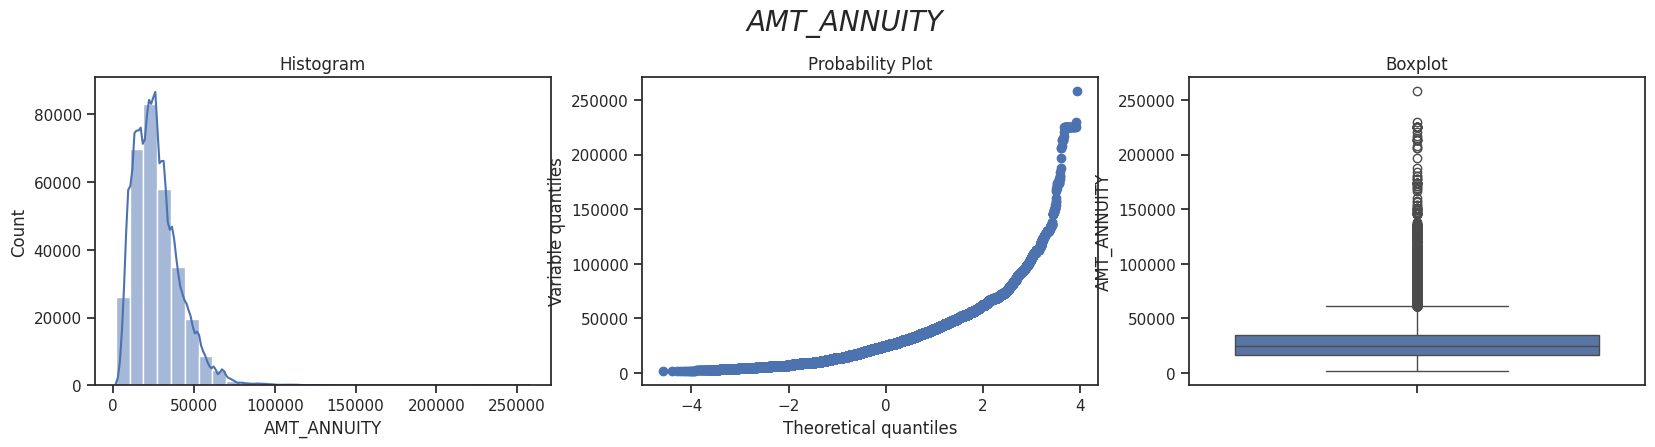

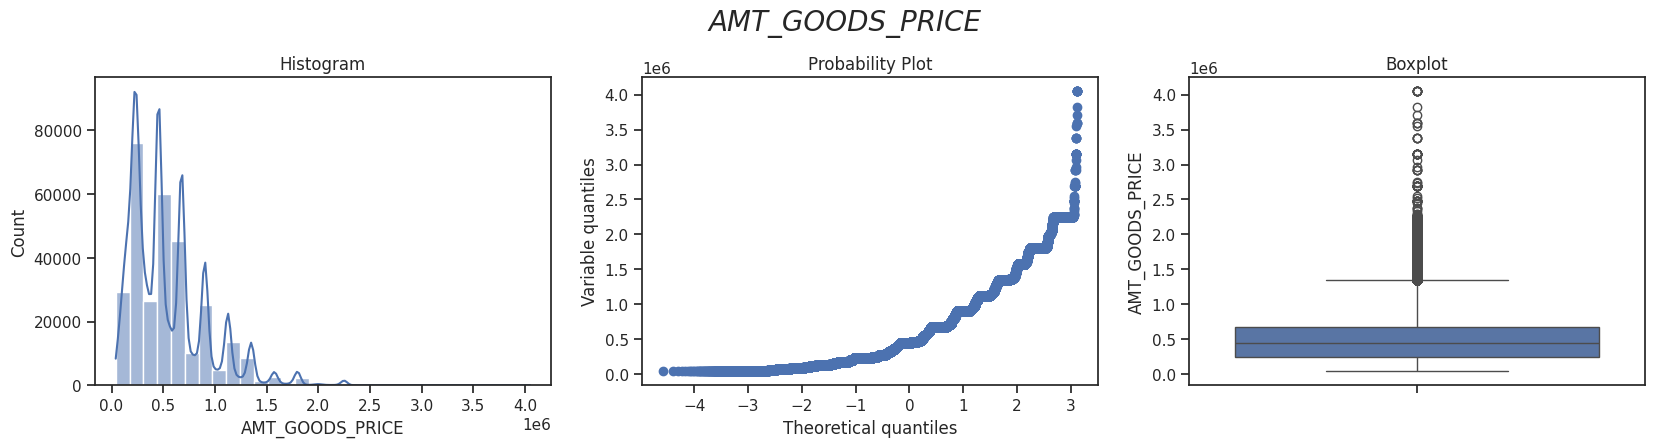

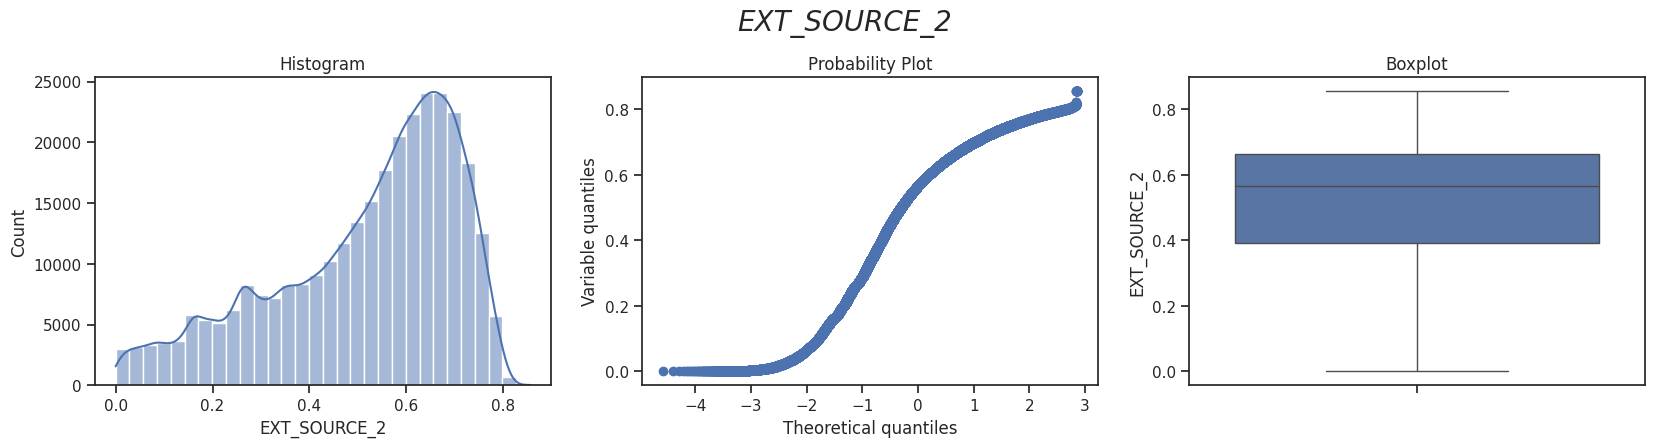

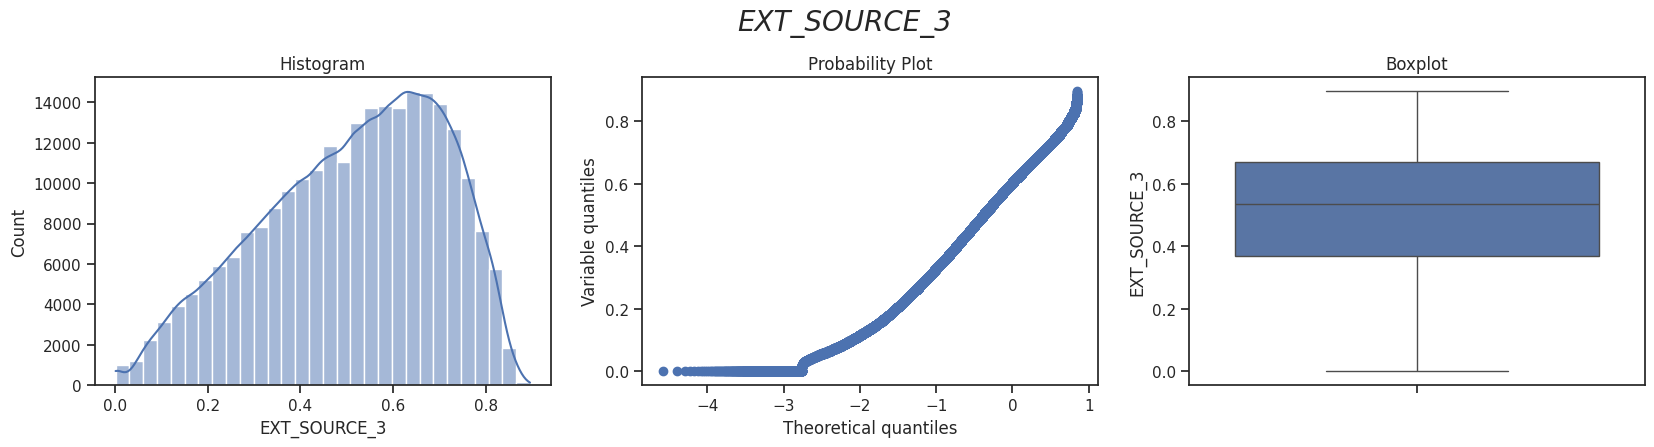

In [155]:
for col in cols:
    multiple_plots(app_train, col, col)

Nous constatons qu'aucune de ces variables ne suit une loi normale. Nous allons confirmer ces résultats en effectuant des tests d'hypothèse et en calculant les statistiques d'asymétrie.

In [156]:
skewness = app_train[cols].skew().rename('Skewness').to_frame()
display(skewness)

,Skewness
AMT_INCOME_TOTAL,391.559654
AMT_CREDIT,1.234778
AMT_ANNUITY,1.579777
AMT_GOODS_PRICE,1.349000
EXT_SOURCE_2,-0.793576
EXT_SOURCE_3,-0.409390


Le résultat montre que les variables EXT_SOURCE_2 et EXT_SOURCE_3 sont légèrement étalées vers la gauche, tandis que les autres variables sont toutes étalées vers la droite.

Effectuons le test de normalité

Pour vérifier la normalité de la distribution de nos variables, nous allons effectuer le test de D'Agostino et Pearson (normaltest). Ce test est basé sur une combinaison des statistiques 𝑧 de skewness (asymétrie) et kurtosis (aplatissement).

In [157]:
alpha = 0.05
normal_test = {}
for col in cols:
    item = []
    print (f"[Test de normalité pour la variable pour la variable - {col}]")
    stat, p = stats.normaltest(app_train[col], nan_policy='omit')
    item.append(f"{p:.2f}")
    print ("Statistics : ", stat, "; p-value : ", p)
    if p < alpha:
        item.append("OUI")
        print("On rejette H0 : la normalité de la distribution est rejetée\n")
    else:
        item.append("NON")
        print("On accepte H0 : la normalité de la distribution est acceptée\n")
    normal_test[col] = item

normal_test = pd.DataFrame(normal_test, columns=cols, index=['p-value', 'Rejet H0']).T
display(normal_test)

[Test de normalité pour la variable pour la variable - AMT_INCOME_TOTAL]
Statistics :  1808234.6742560286 ; p-value :  0.0
On rejette H0 : la normalité de la distribution est rejetée

[Test de normalité pour la variable pour la variable - AMT_CREDIT]
Statistics :  63010.56681797982 ; p-value :  0.0
On rejette H0 : la normalité de la distribution est rejetée

[Test de normalité pour la variable pour la variable - AMT_ANNUITY]
Statistics :  113942.4941549031 ; p-value :  0.0
On rejette H0 : la normalité de la distribution est rejetée

[Test de normalité pour la variable pour la variable - AMT_GOODS_PRICE]
Statistics :  73142.4550301524 ; p-value :  0.0
On rejette H0 : la normalité de la distribution est rejetée

[Test de normalité pour la variable pour la variable - EXT_SOURCE_2]
Statistics :  26544.814457892127 ; p-value :  0.0
On rejette H0 : la normalité de la distribution est rejetée

[Test de normalité pour la variable pour la variable - EXT_SOURCE_3]
Statistics :  17308.51069317634

,p-value,Rejet H0
AMT_INCOME_TOTAL,0.00,OUI
AMT_CREDIT,0.00,OUI
AMT_ANNUITY,0.00,OUI
AMT_GOODS_PRICE,0.00,OUI
EXT_SOURCE_2,0.00,OUI
EXT_SOURCE_3,0.00,OUI


In [158]:
recap_df = skewness.merge(normal_test, left_index=True, right_index=True)
display(recap_df)

,Skewness,p-value,Rejet H0
AMT_INCOME_TOTAL,391.559654,0.00,OUI
AMT_CREDIT,1.234778,0.00,OUI
AMT_ANNUITY,1.579777,0.00,OUI
AMT_GOODS_PRICE,1.349000,0.00,OUI
EXT_SOURCE_2,-0.793576,0.00,OUI
EXT_SOURCE_3,-0.409390,0.00,OUI


#### *FLAG_DOCUMENTS*

Cette variable indique si le client a renseigné le document N°x demandé.

In [159]:
cols = [
    'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7',
    'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
    'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',
    'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'
]


In [160]:
def multiple_bar_plot(df, cols, n_cols=3):

    n_rows = int(np.ceil(len(cols) / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
    axes = axes.flatten()
    total = len(df)
    for i, col in enumerate(cols):
        ax = axes[i]
        sns.countplot(y=df[col], ax=ax, palette="pastel")
        ax.set_title(f'Countplot of {col}')
        ax.set_ylabel('Value')
        ax.set_xlabel('Count')
        for patch in ax.patches:
            count = patch.get_width()
            percentage = f"{(count / total) * 100:.2f}%"
            ax.text(
                    count / 2,
                    patch.get_y() + patch.get_height() / 2,
                    f"{count}({percentage})",
                    va='center',
                    color='darkblue',
                    fontweight='bold',
                    #bbox=dict(facecolor='lightyellow', alpha=0.5)
            )

    # Remove unused subplots
    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

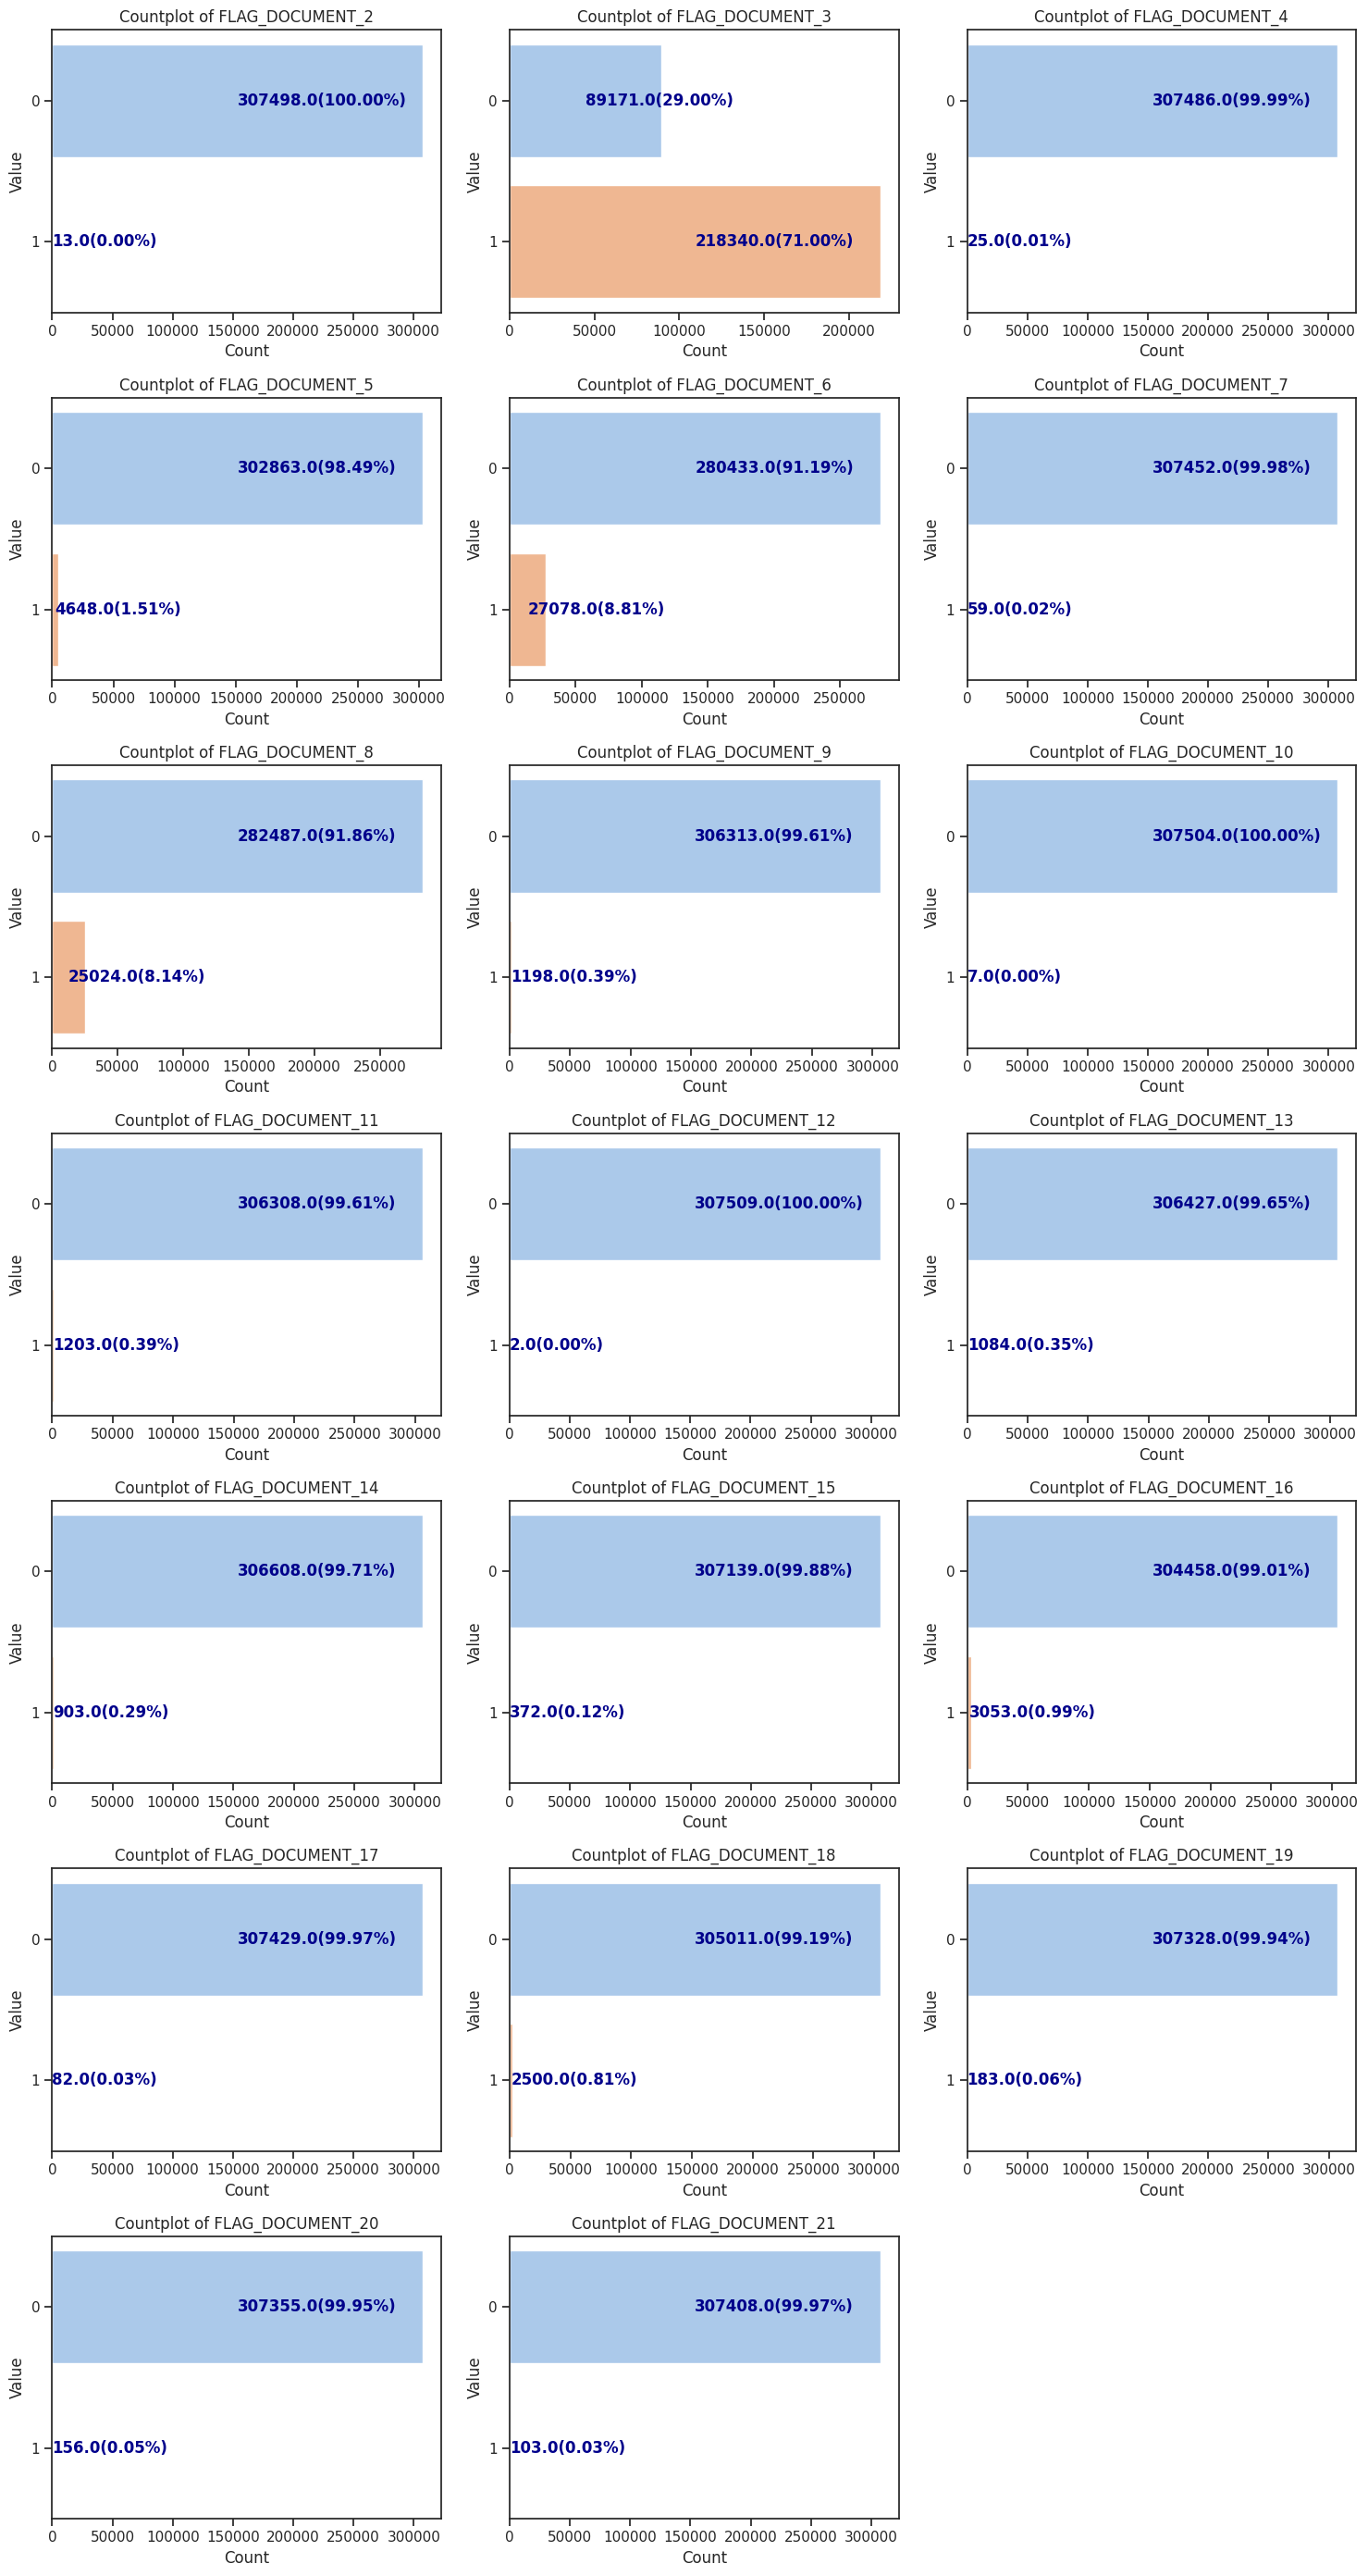

In [161]:
multiple_bar_plot(app_train, cols=cols)

Les diagrammes ci-dessus montrent de forts déséquilibres dans les modalités des variables `flag_documents`. Nous allons conserver les variables `FLAG_DOCUMENT_3` `FLAG_DOCUMENT_6` et `FLAG_DOCUMENT_8` qui présentent une plus grande variance.

Ensuite nous supprimons les variables qui contient une modalité en dessous de 0,80% (`FLAG_DOCUMENT_2`, `FLAG_DOCUMENT_4`, `FLAG_DOCUMENT_7`, `FLAG_DOCUMENT_9`, `FLAG_DOCUMENT_10`, `FLAG_DOCUMENT_11`, `FLAG_DOCUMENT_12`, `FLAG_DOCUMENT_13`, `FLAG_DOCUMENT_14`, `FLAG_DOCUMENT_15`, `FLAG_DOCUMENT_17`, `FLAG_DOCUMENT_18`, `FLAG_DOCUMENT_19`, `FLAG_DOCUMENT_20`, et `FLAG_DOCUMENT_21` )

En ce qui concerne les autres variables, nous poursuivrons l'analyse pour évaluer leur impact sur le défaut de remboursement, puis nous prendrons la décision appropriée.

In [162]:
app_train.groupby('TARGET')[cols].mean()

,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
TARGET,,,,,,,,,,,,,,,,,,,,
0,0.000032,0.704060,0.000088,0.015126,0.090457,0.000198,0.082027,0.003976,0.000025,0.003990,0.000007,0.003729,0.003088,0.001277,0.010269,0.000283,0.008341,0.000605,0.000506,0.000315
1,0.000161,0.777925,0.000000,0.014985,0.060705,0.000121,0.073958,0.002981,0.000000,0.003021,0.000000,0.001208,0.001208,0.000443,0.006042,0.000081,0.005720,0.000483,0.000524,0.000564


Les moyennes des cibles (TARGET) en fonction des FLAG_DOCUMENT montrent des différences relativement faible :

Le tableau montre que la probabilité de la cible (par exemple, un défaut de crédit) est légèrement plus faible pour les individus ayant FLAG_DOCUMENT_X = 1. Cependant, cette différence est petite. Pour elucider l'hypothese de l'indifference de la moyenne nous allons effctuer un test statistique de khi2

In [163]:
flags_to_remove = [
    'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10',
    'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
    'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'
]

# Liste des colonnes à tester
flags_to_test = [
    'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_18'
]


alpha = 0.05
from sklearn.feature_selection import SelectKBest, chi2


X = app_train[flags_to_test]
y = app_train["TARGET"]

# SelectKBest avec le test du chi²
k_best = SelectKBest(chi2, k="all")
k_best.fit(X, y)

scores = k_best.scores_
p_values = k_best.pvalues_

feature_scores = pd.DataFrame({"Feature": flags_to_test, "Score": scores, "p_value": p_values})

feature_scores.sort_values(by="p_value", ascending=True, inplace=True)
display(feature_scores)

,Feature,Score,p_value
1,FLAG_DOCUMENT_16,41.071566,1.467559e-10
2,FLAG_DOCUMENT_18,19.289026,1.123502e-05
0,FLAG_DOCUMENT_5,0.030200,8.620370e-01


In [164]:
#Sélectionner les features avec p-value > alpha
flags_to_remove += feature_scores[feature_scores["p_value"] > alpha]["Feature"].tolist()

print("Colonnes à supprimer:")
print(flags_to_remove)

Colonnes à supprimer:
['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'FLAG_DOCUMENT_5']


Les variables ci dessus sont à supprimer car elles ne sont pas discriminantes pour predire notre variable cible.

In [165]:
# Suppression des colonnes
app_train.drop(columns=flags_to_remove, inplace=True)
app_test.drop(columns=flags_to_remove, inplace=True)


# Aligner les deux datasets
train_labels = app_train['TARGET']

app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)
app_train['TARGET'] = train_labels


print("Les dimensions aprés suppression:")
print(app_train.shape, app_test.shape)

Les dimensions aprés suppression:
(307511, 67) (48744, 66)


In [166]:
app_train.DAYS_ID_PUBLISH.describe()

,DAYS_ID_PUBLISH
count,307511.000000
mean,-2994.202373
std,1509.450419
min,-7197.000000
25%,-4299.000000
50%,-3254.000000
75%,-1720.000000
max,0.000000


## Analyse bivariée

Pour comprendre les données et les corrélations entre les caractéristiques et la cible, nous allons procéder à une analyse bivariée.

Pour ce faire, nous nous appuierons sur des diagrammes et des coefficients statistiques.

Le coefficient de corrélation n'est pas la méthode la plus fiable pour représenter la "pertinence" d'une caractéristique, mais il nous donne une idée des relations possibles dans les données. Voici quelques interprétations générales de la valeur absolue du coefficient de corrélation :

- 0.00-0.19 : “très faible”
- 0.20-0.39 : “faible”
- 0.40-0.59 : “modéré”
- 0.60-0.79 : “fort”
- 0.80-1.0 : “très fort”

In [167]:
app_train_copy = app_train.drop(columns=['SK_ID_CURR'])

In [168]:
# Trouver des correlations avec la variable cible
correlations = app_train_copy.select_dtypes(include=np.number).corr()['TARGET'].sort_values().drop('TARGET')*100

print('Corrélations positives:\n', correlations.tail(15))
print('\nCorrelations negatives:\n', correlations.head(15))

Corrélations positives:
 FLAG_WORK_PHONE                2.852432
DEF_60_CNT_SOCIAL_CIRCLE       3.127647
DEF_30_CNT_SOCIAL_CIRCLE       3.224758
LIVE_CITY_NOT_WORK_CITY        3.251834
DAYS_REGISTRATION              4.197486
FLAG_DOCUMENT_3                4.434635
REG_CITY_NOT_LIVE_CITY         4.439537
FLAG_EMP_PHONE                 4.598222
REG_CITY_NOT_WORK_CITY         5.099446
DAYS_ID_PUBLISH                5.145717
DAYS_LAST_PHONE_CHANGE         5.521848
REGION_RATING_CLIENT           5.889901
REGION_RATING_CLIENT_W_CITY    6.089267
DAYS_EMPLOYED                  7.495846
DAYS_BIRTH                     7.823931
Name: TARGET, dtype: float64

Correlations negatives:
 EXT_SOURCE_3                 -17.891870
EXT_SOURCE_2                 -16.047167
FLOORSMAX_AVG                 -4.400337
FLOORSMAX_MEDI                -4.376792
FLOORSMAX_MODE                -4.322626
AMT_GOODS_PRICE               -3.964528
REGION_POPULATION_RELATIVE    -3.722715
TOTALAREA_MODE                -3.259555


In [169]:
# Diviser les colonnes en groupes de taille fixe 10
columns = list(app_train_copy.select_dtypes(include=np.number).columns)
columns.remove('TARGET')
group_size = 10
groups = [columns[i:i + group_size] for i in range(0, len(columns), group_size)]

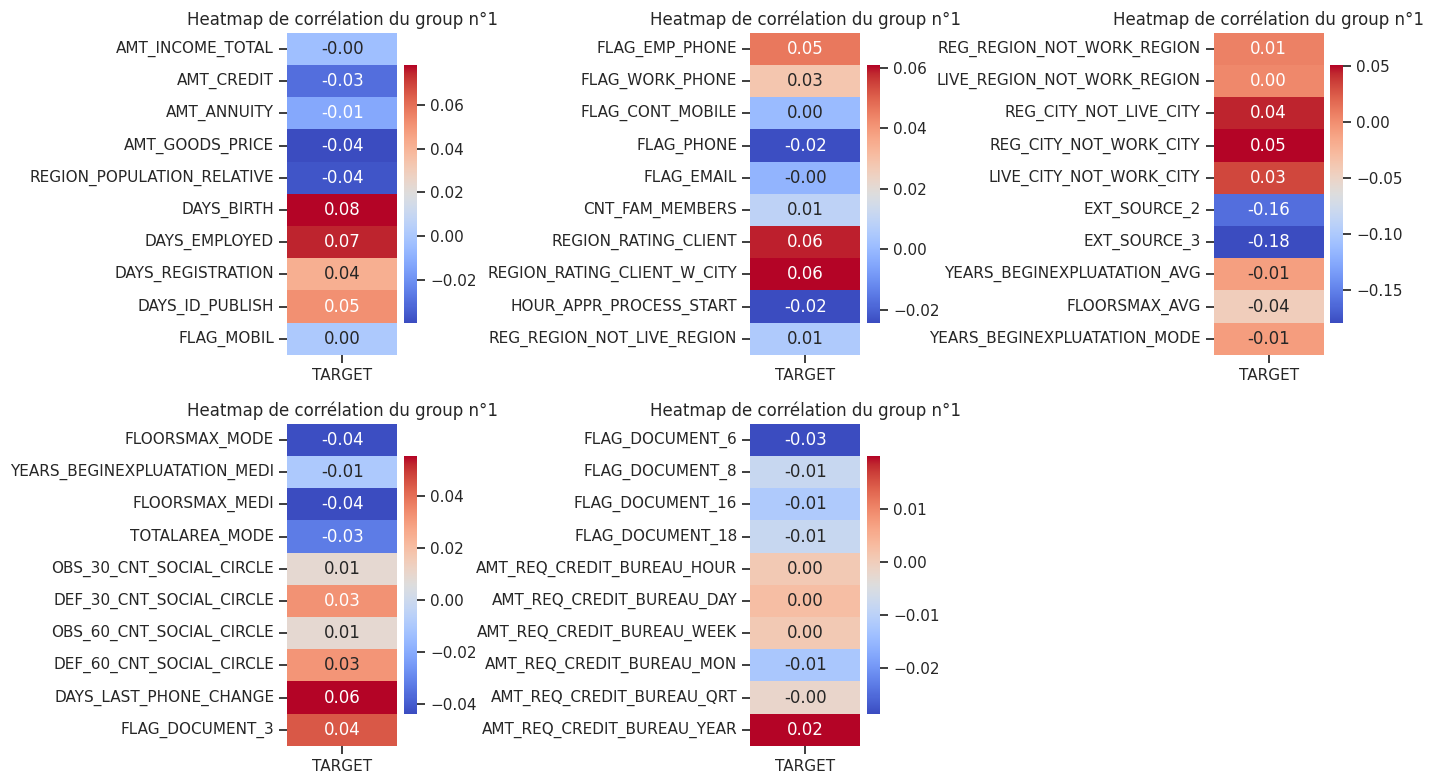

In [170]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()
for i, group in enumerate(groups):
    ax = axes[i]
    group_with_target = group + ['TARGET']
    correlations = app_train_copy[group_with_target].corr()['TARGET'].drop('TARGET')

    sns.heatmap(
        correlations.to_frame(),
        annot=True,
        fmt=".2f",
        cmap="coolwarm",

        cbar_kws={"shrink": .8},
        ax=ax
    )
    ax.set_title(f"Heatmap de corrélation du group n°{1}")

for j in range(len(groups), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Regardons quelques-unes des corrélations les plus significatives : `DAYS_BIRTH` est la corrélation positive (0.08) la plus élevée (à l'exception de `TARGET`, car la corrélation d'une variable avec elle-même est toujours égale à 1 !). En consultant la documentation, on constate que `DAYS_BIRTH` correspond à l'âge du client en jours au moment du prêt, exprimé en jours négatifs (pour une raison quelconque !). La corrélation est positive, mais la valeur de cette variable est en réalité négative, ce qui signifie que plus le client est âgé, moins il est susceptible de faire défaut sur son prêt (c'est-à-dire que la cible == 0). Cela peut prêter à confusion, donc nous allons prendre la valeur absolue de cette variable, ce qui inversera la corrélation en une valeur négative.

Les 2 variables ayant les corrélations négatives les plus fortes avec la cible sont `EXT_SOURCE_2` et `EXT_SOURCE_3`. D'après la documentation, ces variables représentent un "score normalisé provenant d'une source de données externe". Je ne suis pas certain de ce que cela signifie exactement, mais il pourrait s'agir d'une sorte d'évaluation de crédit cumulative basée sur de nombreuses sources de données.

### Effet de l'âge sur le remboursement

In [171]:
app_train_copy['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train_copy['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982694

À mesure que le client vieillit, il existe une relation linéaire négative avec la cible, ce qui signifie que plus les clients sont âgés, plus ils ont tendance à rembourser leurs prêts à temps.  

### Effet des sources exterieures

In [172]:
ext_data = app_train_copy[['TARGET', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.160472,-0.178919,-0.078239
EXT_SOURCE_2,-0.160472,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.091996,0.205478,1.000000


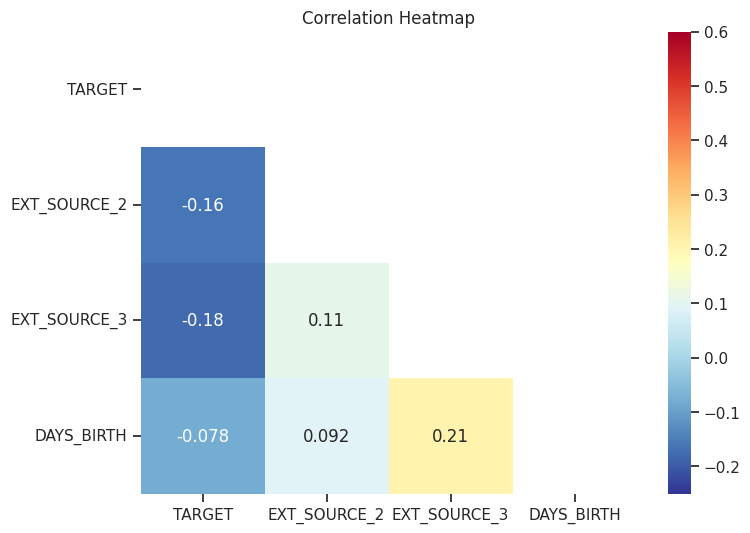

In [173]:
plt.figure(figsize = (8, 6))

mask = np.triu(np.ones_like(ext_data_corrs, dtype=bool))

sns.heatmap(ext_data_corrs, mask=mask, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

Les 2 variables `EXT_SOURCE` ont des corrélations négatives avec la cible, ce qui indique que lorsque la valeur de `EXT_SOURCE` augmente, le client est plus susceptible de rembourser le prêt. On peut également constater que `DAYS_BIRTH` est positivement corrélé avec `EXT_SOURCE_3`, ce qui suggère que l'âge du client pourrait être l'un des facteurs pris en compte dans ce score.  

Ensuite, nous pouvons examiner la distribution de chacune de ces variables, colorée en fonction de la valeur de la cible. Cela nous permettra de visualiser l'effet de ces variables sur la cible.

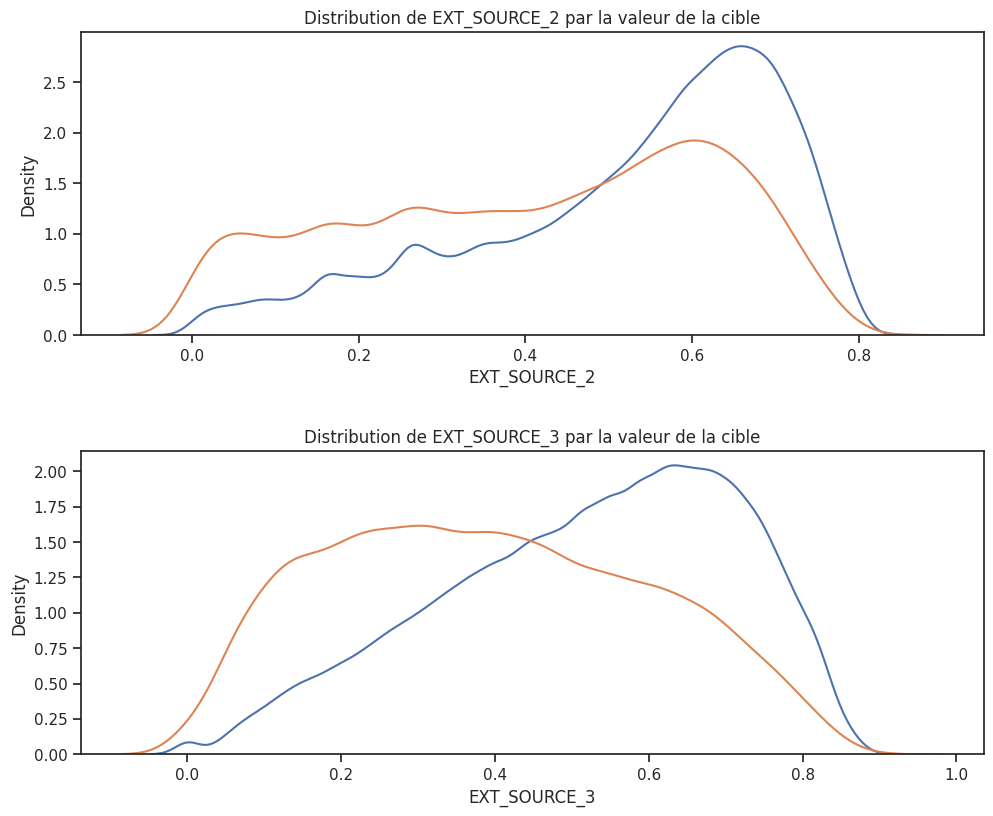

In [174]:
plt.figure(figsize = (10, 12))

for i, source in enumerate(['EXT_SOURCE_2', 'EXT_SOURCE_3']):

    plt.subplot(3, 1, i + 1)
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')

    plt.title('Distribution de %s par la valeur de la cible' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');

plt.tight_layout(h_pad = 2.5)


`EXT_SOURCE_3` montre la plus grande différence entre les valeurs de la cible. On peut clairement voir que cette variable a une certaine relation avec la probabilité qu'un demandeur rembourse un prêt. La relation n'est pas très forte (en fait, elles sont toutes [considérées comme très faibles](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf)), mais ces variables seront tout de même utiles pour un modèle de machine learning visant à prédire si un demandeur remboursera ou non un prêt à temps.

### Pairs Plot

CPU times: user 1min 39s, sys: 1.37 s, total: 1min 40s
Wall time: 1min 30s


Text(0.5, 1.05, 'Source externe et Age')

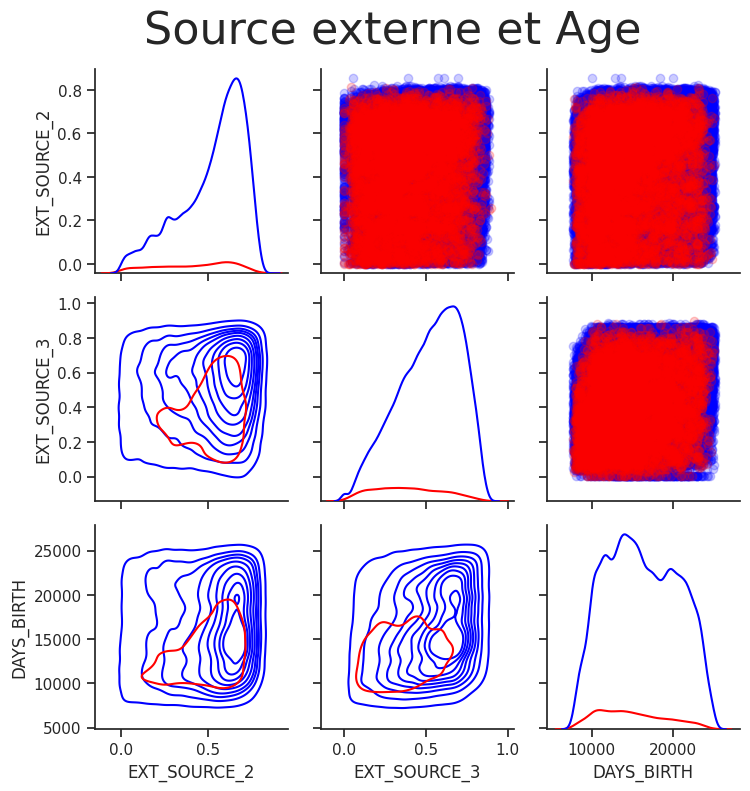

In [175]:
%%time

# Copy the data for plotting
plot_data = ext_data.copy()


# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

custom_palette = {0: "blue", 1: "red"}

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, diag_sharey=False,
                    hue = 'TARGET',
                    palette = custom_palette,
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Source externe et Age', size = 32, y = 1.05);

Sur ce graphique, le rouge indique les prêts qui n'ont pas été remboursés et le bleu représente les prêts remboursés. Nous pouvons observer les différentes relations au sein des données. Il semble y avoir une relation linéaire positive modérée entre `EXT_SOURCE_3` et `DAYS_BIRTH`, ce qui suggère que cette variable pourrait prendre en compte l'âge du client.

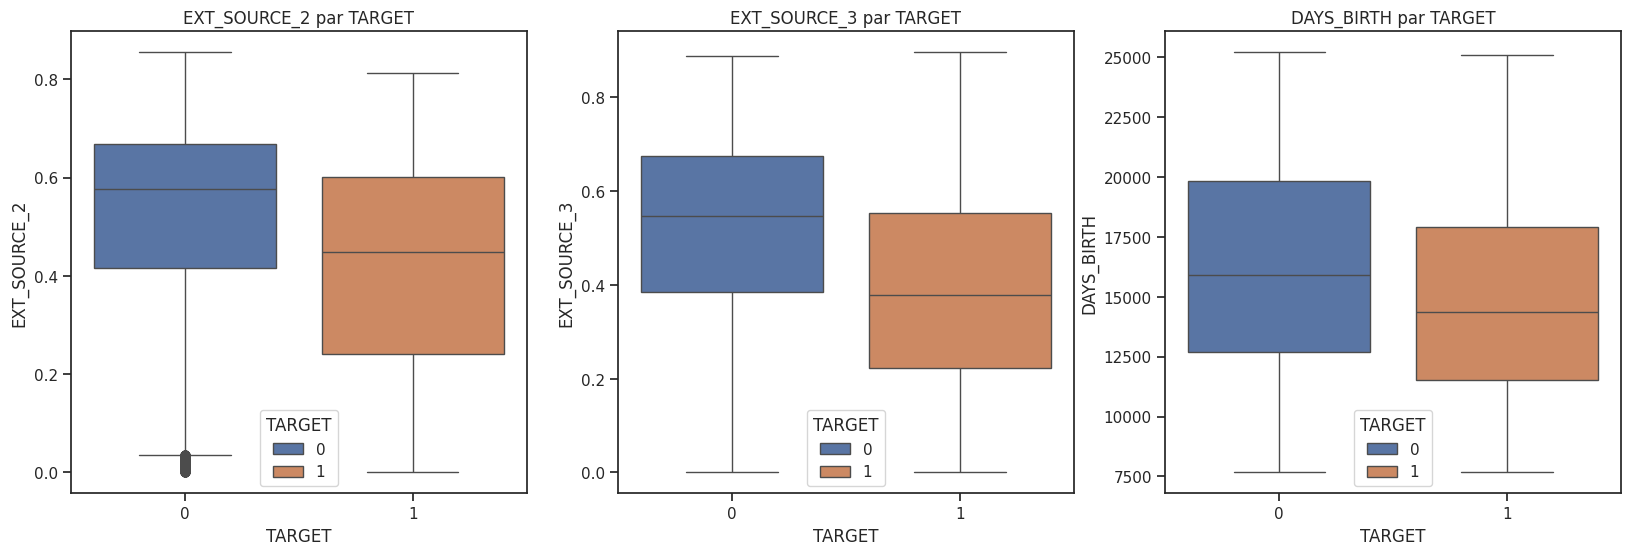

In [176]:
# Créer les boxplots pour EXT_SOURCE_2 et EXT_SOURCE_3 par TARGET
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
sns.boxplot(x="TARGET", y="EXT_SOURCE_2", data=plot_data, hue='TARGET')
plt.title("EXT_SOURCE_2 par TARGET")

plt.subplot(1, 3, 2)
sns.boxplot(x="TARGET", y="EXT_SOURCE_3", data=plot_data, hue='TARGET')
plt.title("EXT_SOURCE_3 par TARGET")

plt.subplot(1, 3, 3)
sns.boxplot(x="TARGET", y="DAYS_BIRTH", data=plot_data, hue='TARGET')
plt.title("DAYS_BIRTH par TARGET")

plt.show()

Hypothèses du test :
1. Hypothèse nulle (H₀) : Les deux groupes proviennent de la même distribution (les médianes des deux groupes sont égales).
2. Hypothèse alternative (H₁) : Les deux groupes proviennent de distributions différentes (les médianes des deux groupes sont différentes).


In [177]:
from scipy.stats import mannwhitneyu
# Test de Mann-Whitney pour voir si les différences sont significatives
ext2_target0 = plot_data[plot_data["TARGET"] == 0]["EXT_SOURCE_2"]
ext2_target1 = plot_data[plot_data["TARGET"] == 1]["EXT_SOURCE_2"]

ext3_target0 = plot_data[plot_data["TARGET"] == 0]["EXT_SOURCE_3"]
ext3_target1 = plot_data[plot_data["TARGET"] == 1]["EXT_SOURCE_3"]

days_birth_target0 = plot_data[plot_data["TARGET"] == 0]["DAYS_BIRTH"]
days_birth_target1 = plot_data[plot_data["TARGET"] == 1]["DAYS_BIRTH"]

stat_ext2, p_ext2 = mannwhitneyu(ext2_target0, ext2_target1, alternative="two-sided")
stat_ext3, p_ext3 = mannwhitneyu(ext3_target0, ext3_target1, alternative="two-sided")
stat_days_birth, p_days_birth = mannwhitneyu(days_birth_target0, days_birth_target1, alternative="two-sided")

alpha = 0.05

if p_ext2 > alpha:
    print("SOURCE_EXT_2 => On accepte H0 : les distributions sont similaires")
else:
    print("SOURCE_EXT_2 => On rejette H0 : les distributions sont différentes")

if p_ext3 > alpha:
    print("SOURCE_EXT_2 => On accepte H0 : les distributions sont similaires")
else:
    print("SOURCE_EXT_2 => On rejette H0 : les distributions sont différentes")

if p_days_birth > alpha:
    print("SOURCE_EXT_2 => On accepte H0 : les distributions sont similaires")
else:
    print("SOURCE_EXT_2 => On rejette H0 : les distributions sont différentes")

test_df = pd.DataFrame(
    {
     "Feature": ['EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'],
     "stat": [stat_ext2, stat_ext3, stat_days_birth],
     "p_value": [p_ext2, p_ext3, p_days_birth]
    }
)


display(test_df)

SOURCE_EXT_2 => On rejette H0 : les distributions sont différentes
SOURCE_EXT_2 => On rejette H0 : les distributions sont différentes
SOURCE_EXT_2 => On rejette H0 : les distributions sont différentes


,Feature,stat,p_value
0,EXT_SOURCE_2,299844407.5,0.000000e+00
1,EXT_SOURCE_3,313139711.5,0.000000e+00
2,DAYS_BIRTH,270062150.0,1.007131e-113


## Sauvegarde des jeux de données

In [178]:
app_train.to_csv(f"{folder_path}/cleaned_app_train.csv", encoding='utf-8', index=None)
app_test.to_csv(f"{folder_path}/cleaned_app_test.csv", encoding='utf-8', index=None)

FIN